In [2]:
import IPython
import os
import pandas as pd
import pathlib
import sys
import matplotlib.pyplot as plt
#from matplotlib import colormaps
import numpy as np 

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from data_pipeline.etl.base import ExtractTransformLoad
from data_pipeline.score import field_names

DATA_DIR = pathlib.Path.cwd().parent / "data"

In [3]:
# Load


basic_rate = 'Percent of individuals below 200% Federal Poverty Line'\
                +', imputed and adjusted'
combined_rate = 'Percentage households below 200% of federal poverty line in'\
                +' 2009 (island areas) and 2010 (states and PR)'
special_territory_percentile =  'Percentage households below 200% of federal poverty line in 2009'\
                                +', adjusted and imputed for island areas (percentile)'

column_dict = {
  'Definition N community, including adjacency index tracts v1.0': 'is_dac_final__v1',
  'Definition N (communities)': 'is_dac_raw__v2',
  'Definition N (communities) (based on adjacency index and low income alone)': 'is_donut_hole__v2',
  'Grandfathered Definition N (communities) from v1.0': 'is_grandfathered',
  'Definition N community, including adjacency index tracts': 'is_dac_final__v2',
  'Percent of individuals below 200% Federal Poverty Line': 'poverty_rate__unadjusted',
  basic_rate: 'basic_rate', #v1 rate
  combined_rate: 'combined_rate', # v2 rate
  basic_rate+' (percentile)': 'basic_percentile', # percentile, except for non-PR territories
  special_territory_percentile: 'special_territory_percentile' # non-PR territory percentiles in v2   
}

path_to_score_file_v2 = DATA_DIR / "score/csv/full/usa.csv"

path_to_score_file_v1 = DATA_DIR / "tmp/Comparator/Score/usa.csv"

scores_v2 = pd.read_csv(
    path_to_score_file_v2,
    dtype={'GEOID10_TRACT': "string"},
).rename(columns=column_dict)

# ok to use the same dictionary to read in v1 scores, because we are discarding most of the columns
scores_v1 = pd.read_csv(
    path_to_score_file_v1,
    dtype={'GEOID10_TRACT': "string"},
).rename(columns=column_dict)

/var/folders/5l/yccn5hf936bdstc1y3zxpbkc0000gn/T/ipykernel_89746/824922383.py:28: DtypeWarning: Columns (1,2,3,78,79,81,82) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_v2 = pd.read_csv(
/var/folders/5l/yccn5hf936bdstc1y3zxpbkc0000gn/T/ipykernel_89746/824922383.py:34: DtypeWarning: Columns (1,2,3,76,77,79,80) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_v1 = pd.read_csv(


In [4]:
set(scores_v2.columns) - set(scores_v1.columns)

{'Percentage households below 200% of federal poverty line in 2009',
 'Percentage households below 200% of federal poverty line in 2009 (percentile)',
 'Percentage households below 200% of federal poverty line in 2009, adjusted and imputed',
 'Percentage households below 200% of federal poverty line in 2009, adjusted and imputed (percentile)',
 'Percentage households below 200% of federal poverty line in 2009, adjusted and imputed exceeds 65th percentile',
 'combined_rate',
 'is_dac_final__v1',
 'is_grandfathered',
 'special_territory_percentile'}

In [5]:
scores_v1['poverty_rate'] = scores_v1['basic_rate']
scores_v1['poverty_percentile'] = scores_v1['basic_percentile']

scores_v2['poverty_rate'] = scores_v2['combined_rate']
scores_v2['poverty_percentile'] = scores_v2['basic_percentile'].fillna(scores_v2['special_territory_percentile'])

In [6]:
scores = scores_v2.merge(
    scores_v1[['GEOID10_TRACT', 'poverty_rate', 'poverty_percentile']],
    how="outer",
    on='GEOID10_TRACT',
    suffixes=("__v2", "__v1"),
)

In [7]:
v2_color = 'C0'
v1_color = 'C1'
added_color = 'C2'
removed_color = 'red'

## Correlations

In [8]:
scores[['poverty_rate__v1', 'poverty_rate__v2']].corr()

,poverty_rate__v1,poverty_rate__v2
poverty_rate__v1,1.000000,0.956505
poverty_rate__v2,0.956505,1.000000


In [9]:
scores[['is_dac_final__v1', 'is_dac_final__v2']].corr()

,is_dac_final__v1,is_dac_final__v2
is_dac_final__v1,1.000000,0.962806
is_dac_final__v2,0.962806,1.000000


## Spotlight on University Areas

In [10]:
uni_dict = {
    '06071004510': 'California State University, San Bernardino',
    '36061020300': 'Columbia University',
    '51650011400': 'Hampton University',
    '51710004700': 'Norfolk State University',
    '06085513000': 'Stanford University 1',
    '06085511608': 'Stanford University 2',
    '01073004500': 'University of Alabama',
    '17031836200': 'University of Chicago',
    '06037222700': 'University of Southern California'
}

uni_tracts = uni_dict.keys()

In [11]:
score_versions = ['v2', 'v1'] 
uni_scores = scores.loc[scores.GEOID10_TRACT.isin(uni_tracts)]
uni_scores['school_name'] = uni_scores.GEOID10_TRACT.apply(lambda x: uni_dict[x])
uni_scores[['GEOID10_TRACT', 'school_name']+['is_dac_final__'+x for x in score_versions]]\
    .sort_values(by='GEOID10_TRACT')

/var/folders/5l/yccn5hf936bdstc1y3zxpbkc0000gn/T/ipykernel_89746/4229035723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uni_scores['school_name'] = uni_scores.GEOID10_TRACT.apply(lambda x: uni_dict[x])


,GEOID10_TRACT,school_name,is_dac_final__v2,is_dac_final__v1
861,01073004500,University of Alabama,True,False
6992,06037222700,University of Southern California,True,False
4764,06071004510,"California State University, San Bernardino",True,False
8901,06085511608,Stanford University 2,False,False
4403,06085513000,Stanford University 1,False,False
23695,17031836200,University of Chicago,False,False
46307,36061020300,Columbia University,False,False
69220,51650011400,Hampton University,False,False
69512,51710004700,Norfolk State University,True,True


## Total Added and Grandfathered

In [12]:
n_null = sum(scores.is_dac_final__v2.isnull())
n_grandfathered = sum(scores.is_grandfathered)
n_diff = sum(scores.is_dac_final__v2!=scores.is_dac_final__v1)
n_added = len(scores[(scores.is_dac_final__v2==True) & (scores.is_dac_final__v1==False)])
n_removed = len(scores[(scores.is_dac_final__v2==False) & (scores.is_dac_final__v1==True)])

assert n_null==0
assert n_removed==0
assert n_diff==n_added

print(f'Number of tracts added to DAC list in v2: {n_added}')
print(f'Number of tracts that would have been removed in v2, but grandfathered in: {n_grandfathered}')

Number of tracts added to DAC list in v2: 1319
Number of tracts that would have been removed in v2, but grandfathered in: 1505


In [13]:
scores.is_dac_final__v2.sum()

28567

## Plotting prep

In [14]:
def uni_bucket(x):
    if x<0.2:
        return "0-19%"
    if x<0.5:
        return "20-49%"
    if x<0.7:
        return "50-69%"
    if x<0.9:
        return "70-89%"
    return "90-100%"

scores['university_attendance_bucketed'] \
    = scores['Percent enrollment in college or graduate school'].apply(uni_bucket)

In [15]:
scores['university_attendance_bucketed'].value_counts(normalize=True)

0-19%      0.953004
20-49%     0.024348
90-100%    0.014191
50-69%     0.005247
70-89%     0.003210
Name: university_attendance_bucketed, dtype: float64

In [16]:
scores['Urban Heuristic Flag'].value_counts(normalize=True)

1.0    0.805573
0.0    0.194427
Name: Urban Heuristic Flag, dtype: float64

In [17]:
scores['urban_population'] = scores['Total population'] * scores['Urban Heuristic Flag']
scores['urban_population'].sum( min_count=1)/scores['Total population'].sum(min_count=1)

0.8198511256593899

In [18]:
urban_dict = {1.0: 'Non-Rural', 0.0: 'Rural'}
scores['rural_flag_string'] = scores['Urban Heuristic Flag'].map(urban_dict)
scores['rural_flag_string'].value_counts(normalize=True)

Non-Rural    0.805573
Rural        0.194427
Name: rural_flag_string, dtype: float64

In [19]:
state_to_fips_dict = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

territories_dict = {
    '60': 'AS (American Samoa)',
    '64': 'FM (Federated States of Micronesia)',
    '66': 'GU (Guam)',
    '68': 'MH (Marshall Islands)',
    '69': 'MP (Commonwealth of the Northern Mariana Islands)',
    '70': 'PW (Palau)',
    '72': 'PR (Puerto Rico)',
    '74': 'UM (U.S. Minor Outlying Islands)',
    '78': 'VI (U.S. Virgin Islands)',
    '81': 'Baker Island',
    '84': 'Howland Island',
    '86' : 'Jarvis Island',
    '67' : 'Johnston Atoll',
    '89' : 'Kingman Reef',
    '71' : 'Midway Islands',
    '76' : 'Navassa Island',
    '95' : 'Palmyra Atoll',
    '79' : 'Wake Island',
    }

fips_to_state_dict = {v:k for k,v in state_to_fips_dict.items()}
fips_to_state_dict.update(territories_dict)

scores['state_fips']=scores['GEOID10_TRACT'].str[:2]
scores['state']=scores['state_fips'].map(fips_to_state_dict)
scores[['state', 'state_fips', 'GEOID10_TRACT']].head()

,state,state_fips,GEOID10_TRACT
0,AL,01,01073001100
1,AL,01,01073001400
2,AL,01,01073002000
3,AL,01,01073003802
4,AL,01,01073004000


In [20]:
# Assigning geographic regions and divisions
# source: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

territory_names = territories_dict.values()
non_pr_territory_names = [x for x in territory_names if 'Puerto Rico' not in x]

# easier to write this way
division_dict_backwards = {
    'New England': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT'],
    'Middle Atlantic': ['NJ', 'NY', 'PA'],
    'East North Central': ['IN', 'IL', 'MI', 'OH', 'WI'],
    'West North Central': ['IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South Atlantic': ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV'],
    'East South Central': ['AL', 'KY', 'MS', 'TN'],
    'West South Central': ['AR', 'LA', 'OK', 'TX'],
    'Mountain': ['AZ', 'CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY'],
    'Pacific': ['AK', 'CA', 'HI', 'OR', 'WA'],
    'Puerto Rico': ['PR (Puerto Rico)'],
    'Other Territories': non_pr_territory_names
}

region_dict = {'New England': 'Northeast',
              'Middle Atlantic': 'Northeast',
              'East North Central': 'Midwest',
              'West North Central': 'Midwest',
              'South Atlantic': 'South',
              'East South Central': 'South',
              'West South Central': 'South',
              'Mountain': 'West',
              'Pacific': 'West',
              'Puerto Rico': 'Puerto Rico',
              'Other Territories': 'Other Territories'}

division_dict={}
for k,v in division_dict_backwards.items():
    for x in v:
        division_dict[x]=k

scores['division'] = scores['state'].map(division_dict)
scores['region'] = scores['division'].map(region_dict)
scores[['GEOID10_TRACT', 'state_fips', 'state', 'division', 'region']].head()

,GEOID10_TRACT,state_fips,state,division,region
0,01073001100,01,AL,East South Central,South
1,01073001400,01,AL,East South Central,South
2,01073002000,01,AL,East South Central,South
3,01073003802,01,AL,East South Central,South
4,01073004000,01,AL,East South Central,South


In [21]:
v1 = 'v1'
v2 = 'v2'
score_versions = [v2, v1] 

methods = ['poverty_rate__'+x for x in score_versions]
methods_percentiles = ['poverty_percentile__'+x for x in score_versions]

## Distribution of Adjusted Poverty Rates

### Adjusted Poverty Rates, Overall

In [22]:
scores[methods].describe().T

,count,mean,std,min,25%,50%,75%,max
poverty_rate__v2,74093.0,0.320690,0.191483,0.0,0.168928,0.292223,0.445412,1.0
poverty_rate__v1,73273.0,0.255027,0.187659,0.0,0.101987,0.227329,0.376717,1.0


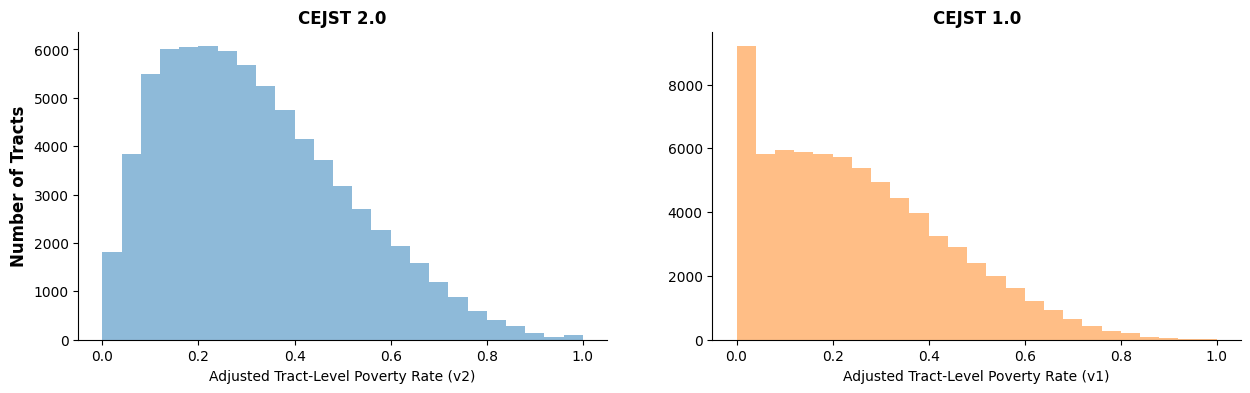

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True)

for m, method in enumerate(methods):
    if 'v1' in method:
        c=v1_color
    elif 'v2' in method:
        c=v2_color
    ax[m].hist(scores[method], bins=25, alpha=0.5, color=c)
    if m==0:
        ax[m].set_ylabel('Number of Tracts', fontsize=12, fontweight='bold')
    ax[m].set_title(f"CEJST {method.replace('poverty_rate__v', '')}.0", fontweight='bold')
    ax[m].xaxis.set_tick_params(labelbottom=True)
    ax[m].set_xlabel(f"Adjusted Tract-Level Poverty Rate ({method.replace('poverty_rate__', '')})")
    ax[m].spines[['right', 'top']].set_visible(False)

### Adjusted Poverty Rates, by Region

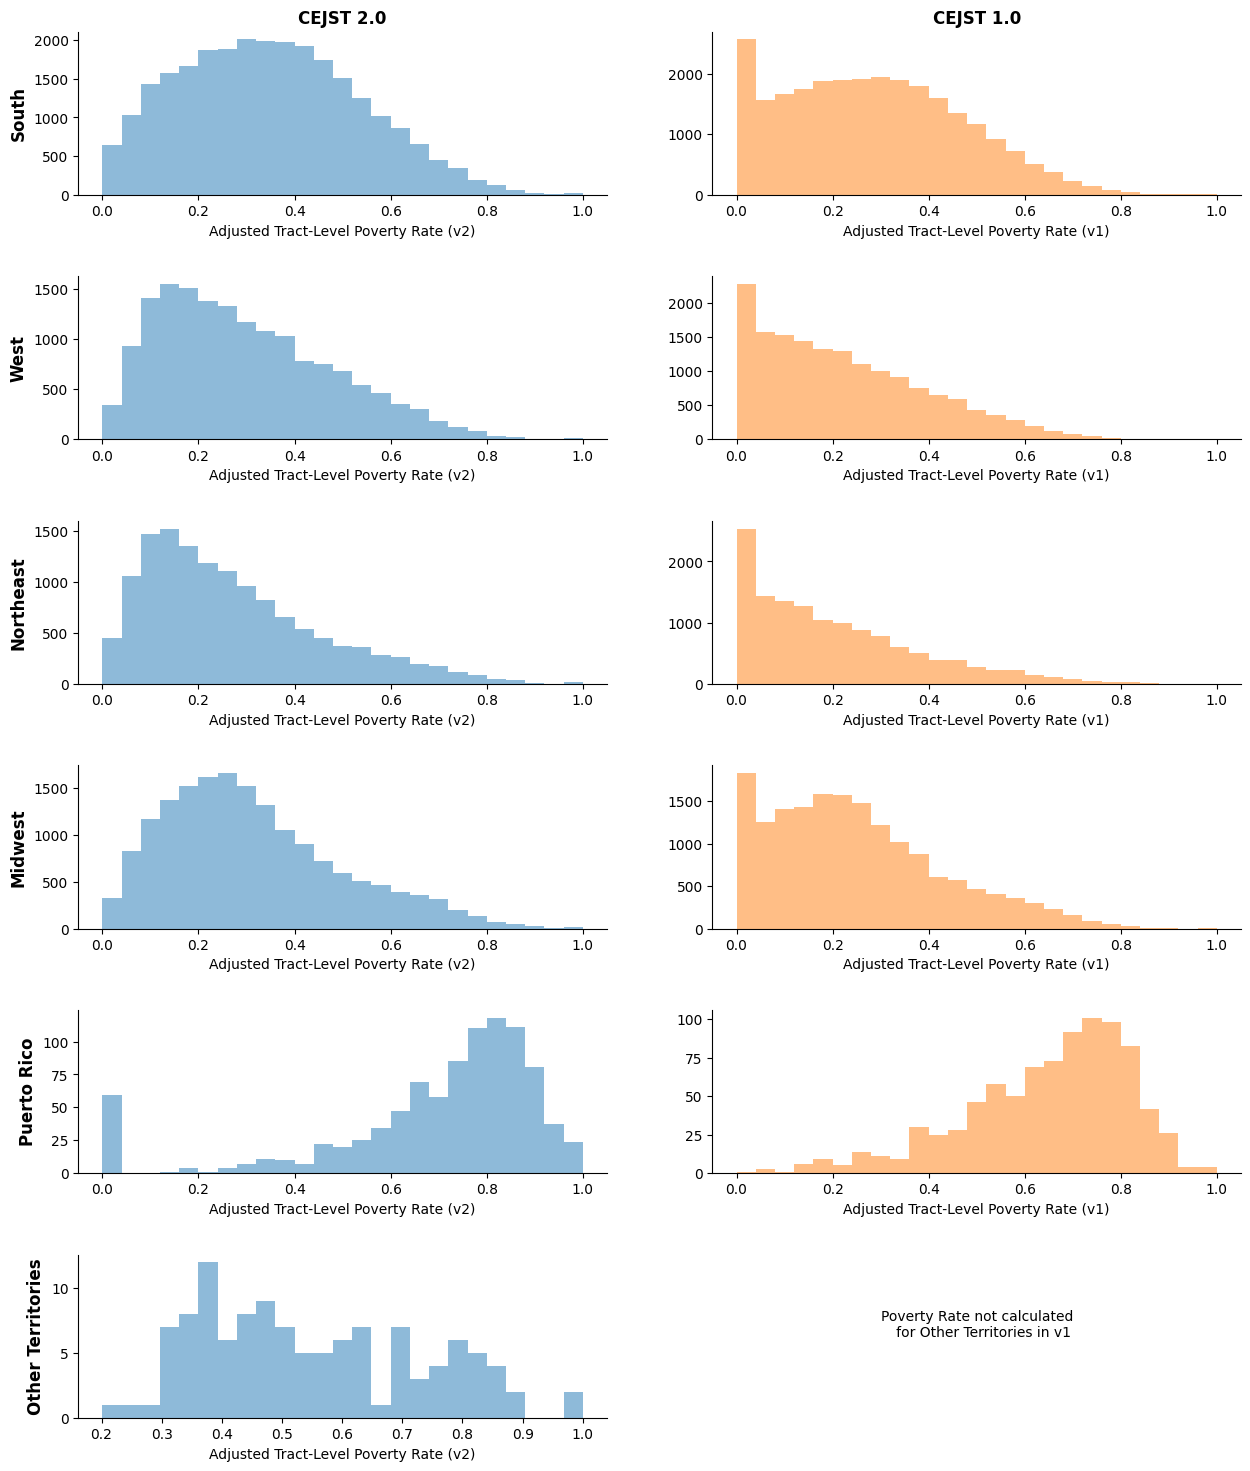

In [24]:
fig, ax = plt.subplots(6, 2, figsize=(15,18), sharex=False)

for r, region in enumerate(scores['region'].unique()):
    region_df = scores[scores.region==region]
    for m, method in enumerate(methods):
        nice_method = method.replace('poverty_rate__', '')
        if all(region_df[method].isna()):
            ax[r][m].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
            ax[r][m].tick_params(axis="both", bottom=False, left=False)
            ax[r][m].set_xticks([])
            ax[r][m].set_yticks([])
            ax[r][m].text(x=0.5, y=0.5, 
                          s=f"\n\nPoverty Rate not calculated\n   for {region} in {nice_method}", 
                          horizontalalignment='center')
        else:
            if 'v1' in method:
                c=v1_color
            elif 'v2' in method:
                c=v2_color
            ax[r][m].hist(region_df[method], bins=25, alpha=0.5, color=c)
            ax[r][m].xaxis.set_tick_params(labelbottom=True)
            ax[r][m].set_xlabel(f"Adjusted Tract-Level Poverty Rate ({nice_method})")
            ax[r][m].spines[['right', 'top']].set_visible(False)
        if m==0:
                ax[r][m].set_ylabel(region, fontsize=12, fontweight='bold')
        if r==0:
            ax[r][m].set_title(f"CEJST {nice_method.replace('v', '')}.0", fontweight='bold')

plt.subplots_adjust(hspace=0.5)

### Adjusted Poverty Rates, by University Enrollment Rate

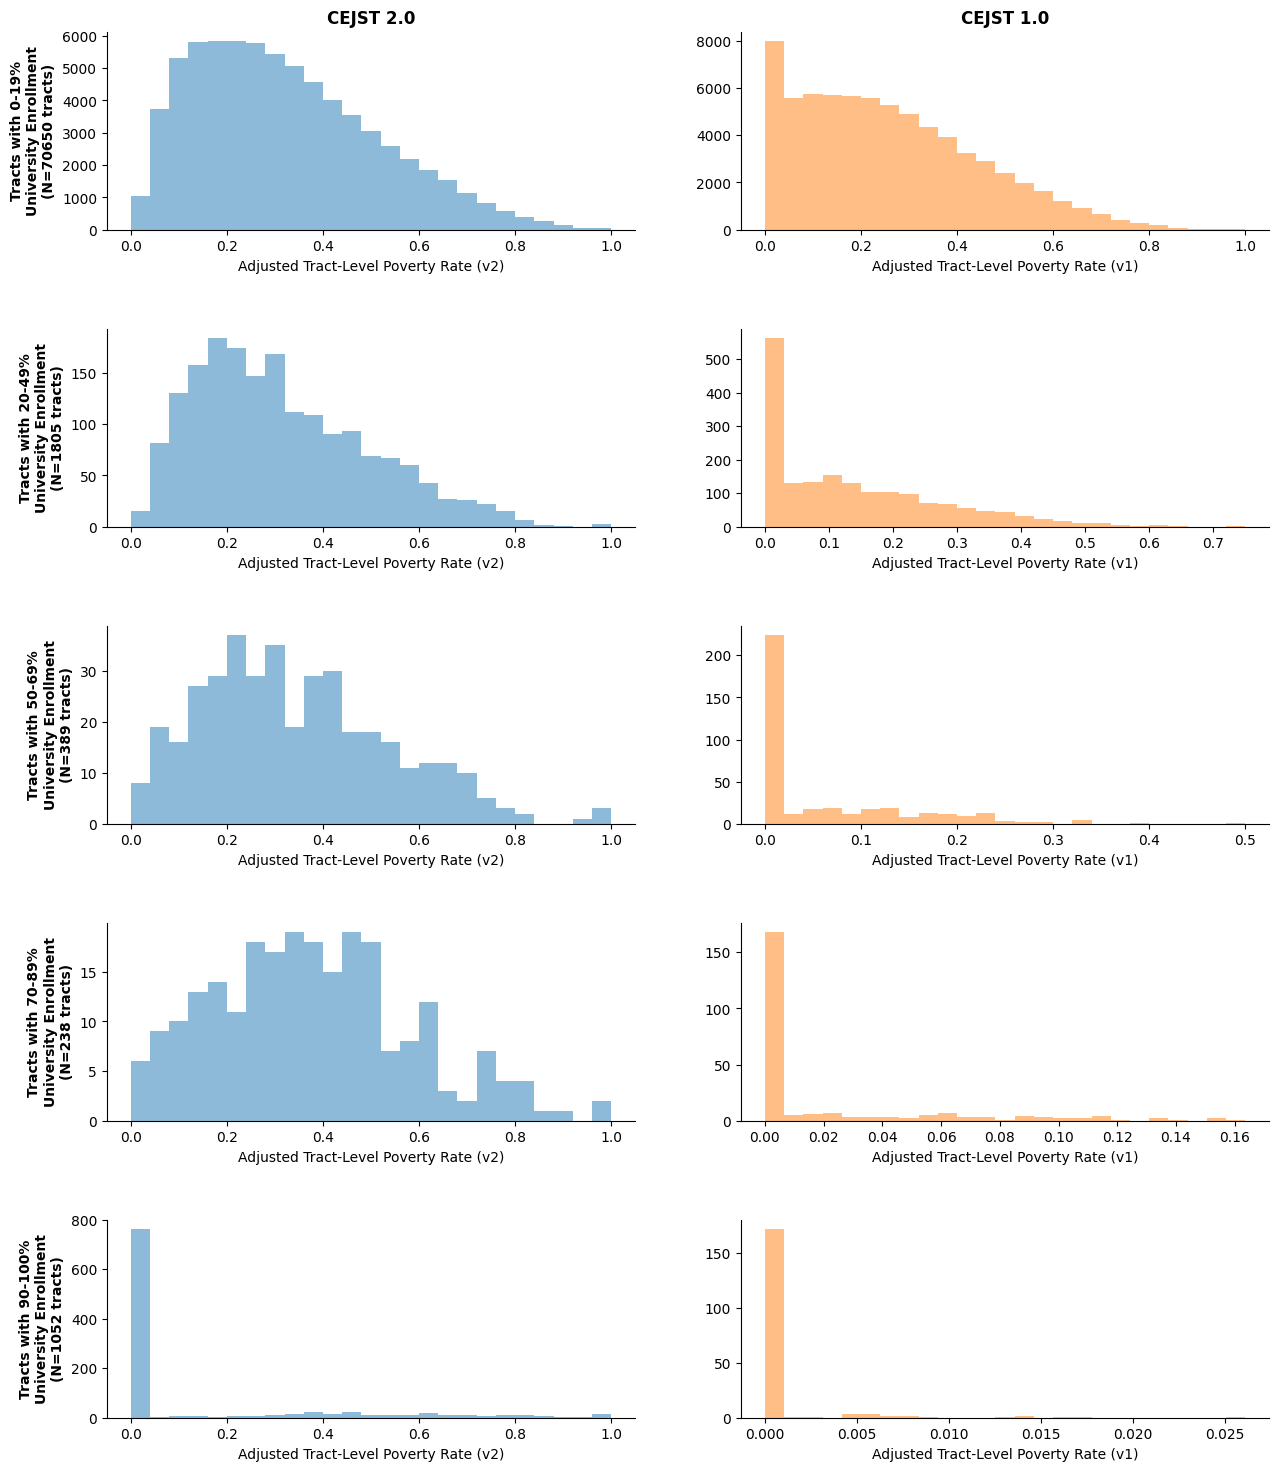

In [25]:
fig, ax = plt.subplots(5, 2, figsize=(15,18), sharex=False)

for b, bucket in enumerate(scores['university_attendance_bucketed'].unique()):
    bucket_df = scores[scores.university_attendance_bucketed==bucket]
    for m, method in enumerate(methods):
        if 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], bins=25, alpha=0.5, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'Tracts with {bucket}\nUniversity Enrollment\n(N={len(bucket_df)} tracts)',
                               fontweight='bold')
        if b==0:
            ax[b][m].set_title(f"CEJST {method.replace('poverty_rate__v', '')}.0", fontweight='bold')
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        ax[b][m].set_xlabel(f"Adjusted Tract-Level Poverty Rate ({method.replace('poverty_rate__', '')})")
        ax[b][m].spines[['right', 'top']].set_visible(False)
        
plt.subplots_adjust(hspace=0.5)

### Adjusted Poverty Rates, by Housing Density

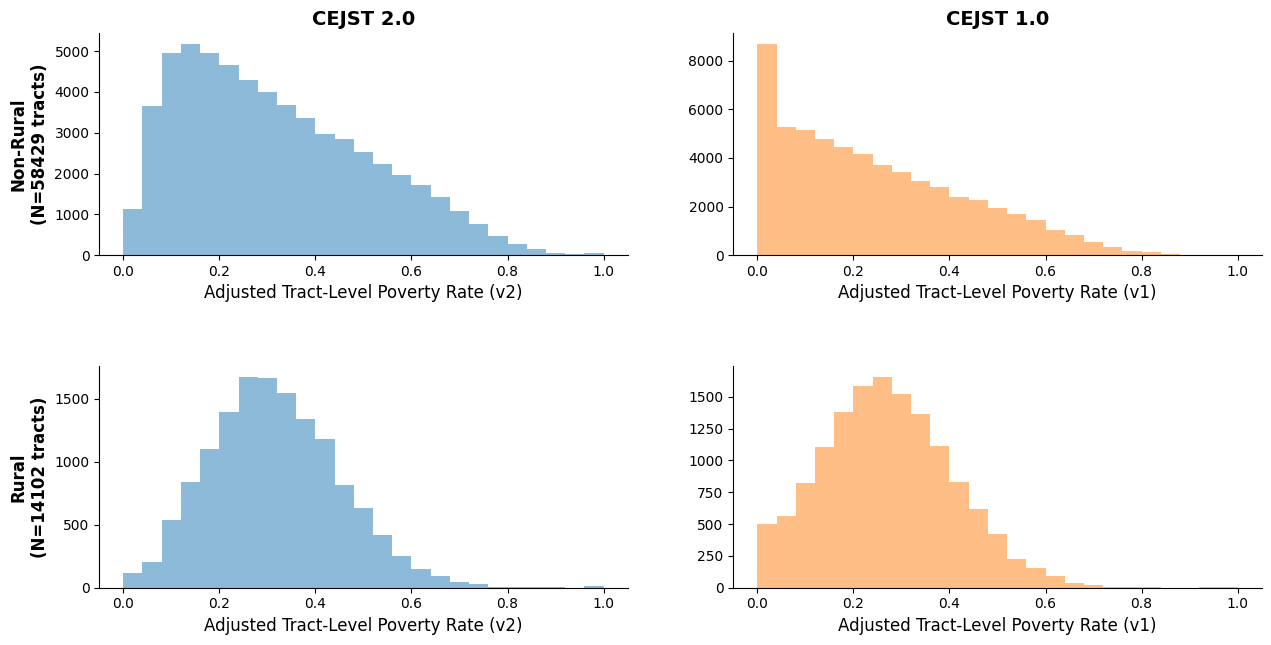

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(15,7.2), sharex=False)

for b, bucket in enumerate(scores['rural_flag_string'].unique()):
    if bucket!=bucket:
        continue
    bucket_df = scores[scores['rural_flag_string']==bucket]
    for m, method in enumerate(methods):
        if 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], bins=25, alpha=0.5, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'{bucket}\n(N={len(bucket_df)} tracts)', fontsize=12,
                               fontweight='bold')
        if b==0:
            ax[b][m].set_title(f"CEJST {method.replace('poverty_rate__v', '')}.0", 
                               fontweight='bold', fontsize=14)
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        ax[b][m].set_xlabel(f"Adjusted Tract-Level Poverty Rate ({method.replace('poverty_rate__', '')})",
                           fontsize=12)
        ax[b][m].spines[['right', 'top']].set_visible(False)
        
plt.subplots_adjust(hspace=0.5)

## Distribution of Low Income Percentiles

### Distribution of Low Income Percentiles, by Region

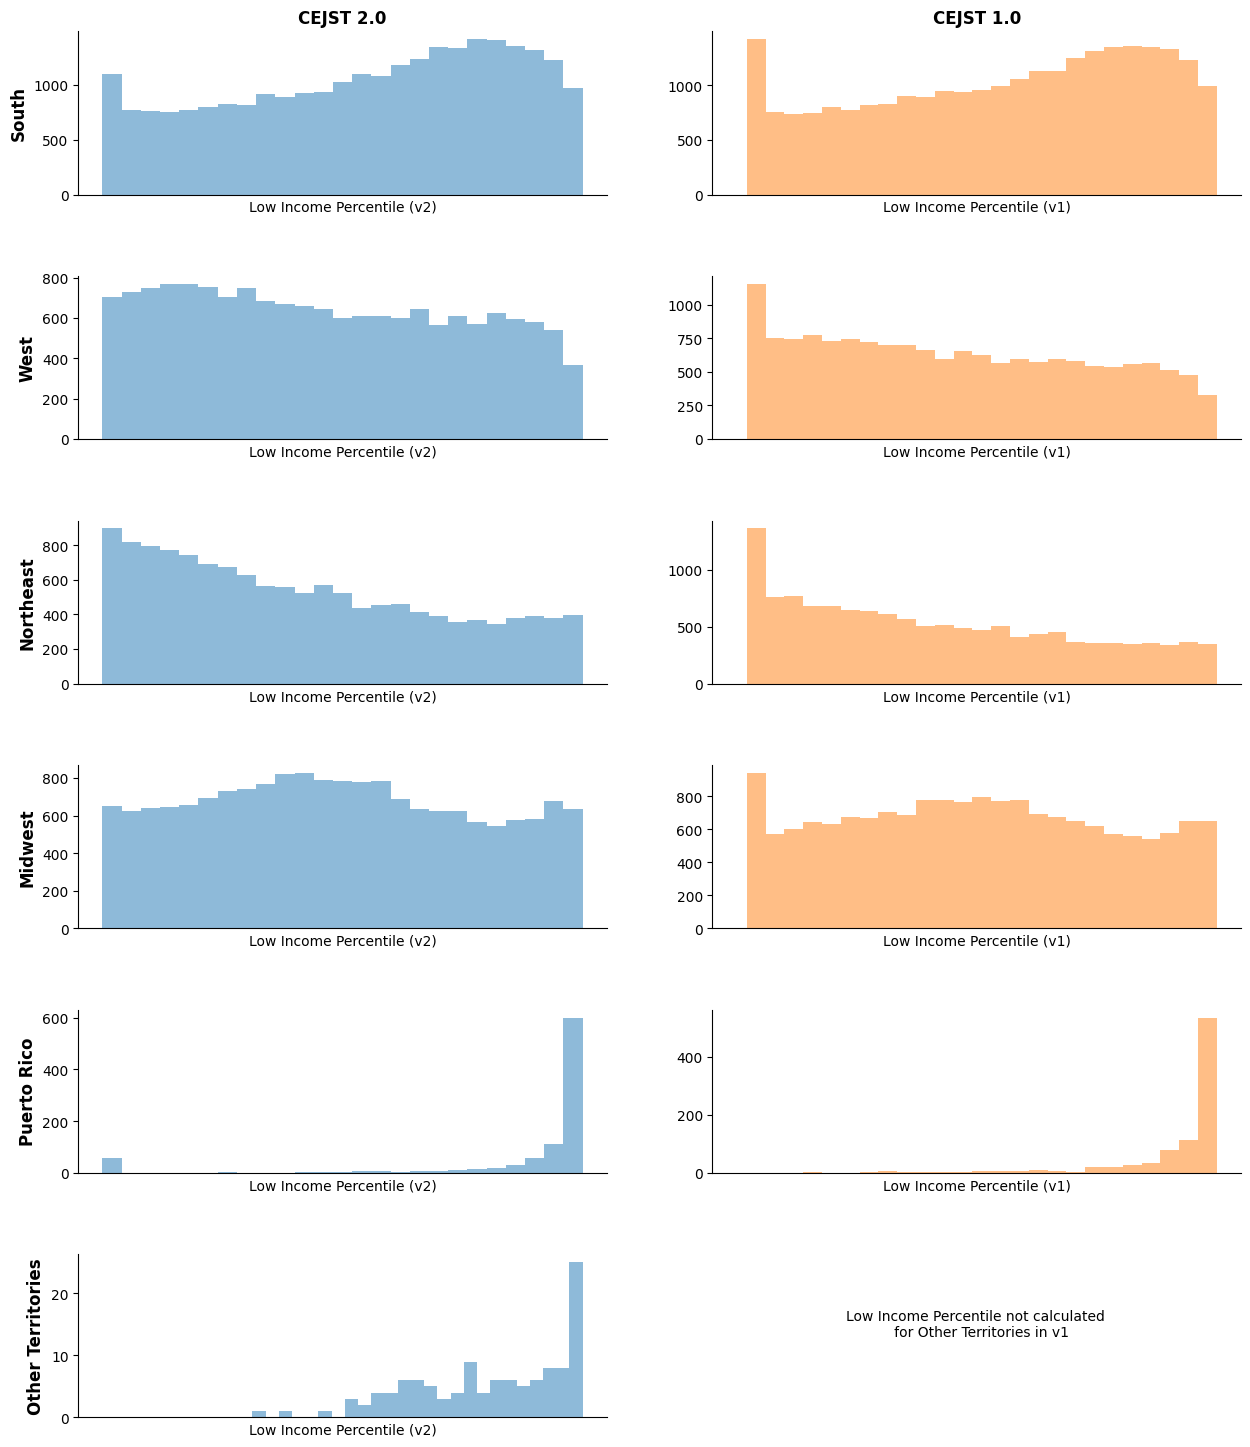

In [27]:
fig, ax = plt.subplots(6, 2, figsize=(15,18), sharex=True)

for r, region in enumerate(scores['region'].unique()):
    region_df = scores[scores.region==region]
    for m, method in enumerate(methods_percentiles):
        if all(region_df[method].isna()):
            ax[r][m].spines[['right', 'top', 'bottom', 'left']].set_visible(False)
            ax[r][m].tick_params(axis="both", bottom=False, left=False)
            ax[r][m].set_xticks([])
            ax[r][m].set_yticks([])
            ax[r][m].text(x=0.5, y=0.5, 
                          s=f"\n\nLow Income Percentile not calculated\n   for {region} in {nice_method}", 
                          horizontalalignment='center')
        else:
            if 'v1' in method:
                c=v1_color
            elif 'v2' in method:
                c=v2_color
            ax[r][m].hist(region_df[method], bins=25, alpha=0.5, color=c)

            ax[r][m].xaxis.set_tick_params(labelbottom=True)
            ax[r][m].set_xlabel(f"Low Income Percentile ({method.replace('poverty_percentile__', '')})")
            ax[r][m].spines[['right', 'top']].set_visible(False)
        if m==0:
            ax[r][m].set_ylabel(region, fontsize=12, fontweight='bold')
        if r==0:
            ax[r][m].set_title(f"CEJST {method.replace('poverty_percentile__v', '')}.0", fontweight='bold')
plt.subplots_adjust(hspace=0.5)

### Distribution of Low Income Percentiles, by University Enrollment Rate

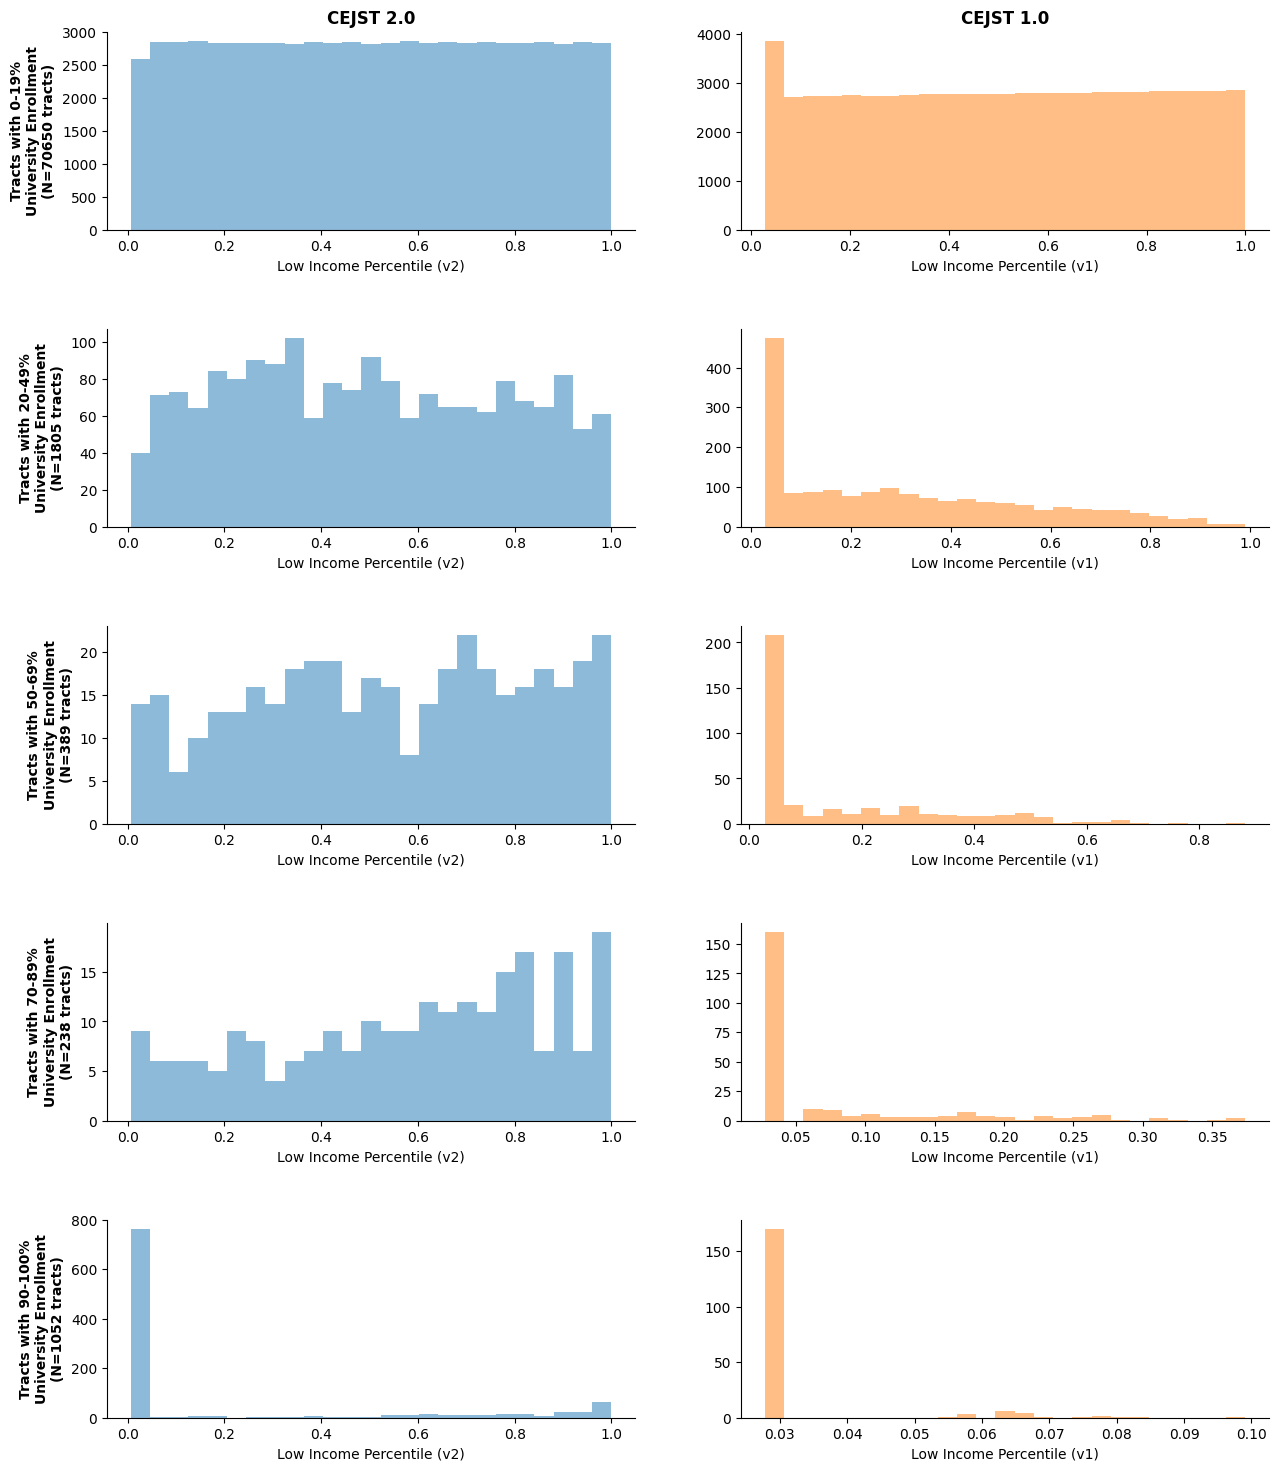

In [28]:
fig, ax = plt.subplots(5, 2, figsize=(15,18), sharex=False)

for b, bucket in enumerate(scores['university_attendance_bucketed'].unique()):
    bucket_df = scores[scores.university_attendance_bucketed==bucket]
    for m, method in enumerate(methods_percentiles):
        if 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], bins=25, alpha=0.5, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'Tracts with {bucket}\nUniversity Enrollment\n(N={len(bucket_df)} tracts)',
                               fontweight='bold')
        if b==0:
            ax[b][m].set_title(f"CEJST {method.replace('poverty_percentile__v', '')}.0", fontweight='bold')
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        ax[b][m].set_xlabel(f"Low Income Percentile ({method.replace('poverty_percentile__', '')})")
        ax[b][m].spines[['right', 'top']].set_visible(False)
plt.subplots_adjust(hspace=0.5)

### Distribution of Low Income Percentile, by Housing Density

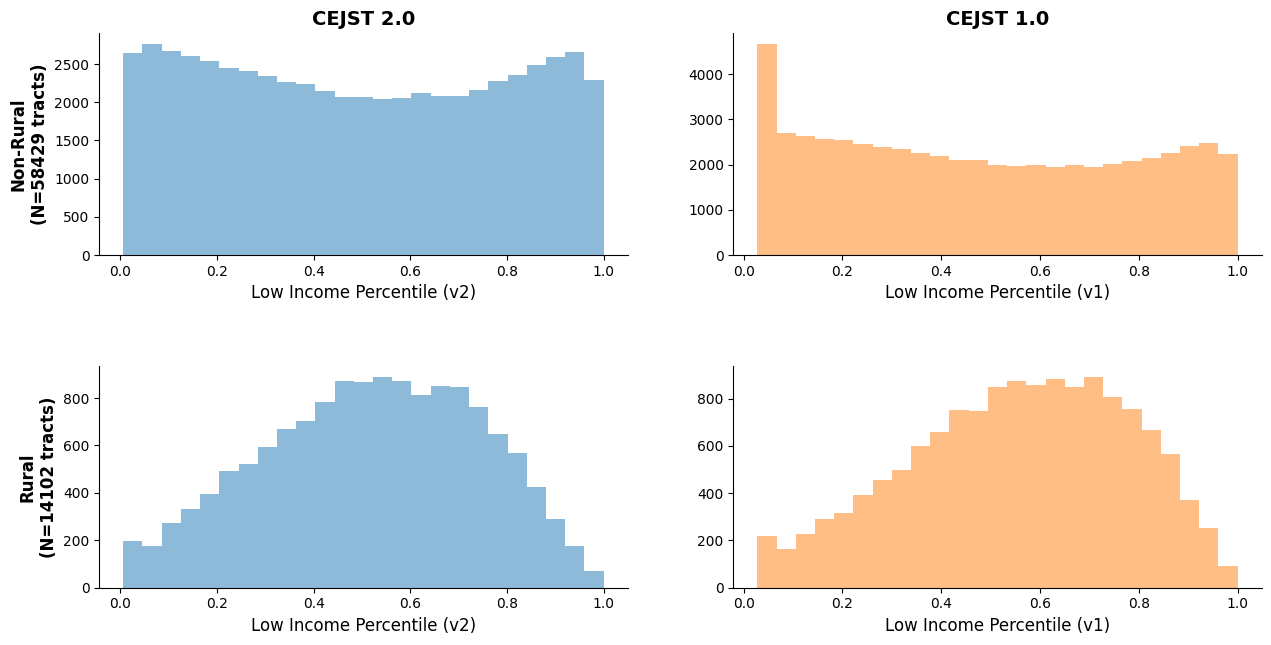

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(15,7.2), sharex=False)

for b, bucket in enumerate(scores['rural_flag_string'].unique()):
    if bucket!=bucket:
        continue
    bucket_df = scores[scores.rural_flag_string==bucket]
    for m, method in enumerate(methods_percentiles):
        if 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], bins=25, alpha=0.5, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'{bucket}\n(N={len(bucket_df)} tracts)',
                               fontweight='bold', fontsize=12)
        if b==0:
            ax[b][m].set_title(f"CEJST {method.replace('poverty_percentile__v', '')}.0", 
                               fontweight='bold', fontsize=14)
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        ax[b][m].set_xlabel(f"Low Income Percentile ({method.replace('poverty_percentile__', '')})", 
                           fontsize=12)
        ax[b][m].spines[['right', 'top']].set_visible(False)
plt.subplots_adjust(hspace=0.5)

## Distribution of Changes

### Distribution of Changes, Overall

In [30]:
scores['v2_vs_v1'] = scores['poverty_rate__v2'] - scores['poverty_rate__v1']
scores['v2_vs_unadjusted'] = scores['poverty_rate__v2'] - scores['poverty_rate__unadjusted']
scores['v1_vs_unadjusted'] = scores['poverty_rate__v1'] - scores['poverty_rate__unadjusted']
scores['v2_vs_v1_percentiles'] = scores['poverty_percentile__v2'] - scores['poverty_percentile__v1']
all_adjustments = ['v2_vs_v1', 'v2_vs_unadjusted', 'v1_vs_unadjusted', 'v2_vs_v1_percentiles']
adjustments = [x for x in all_adjustments if 'unadjusted' not in x]

scores[all_adjustments].describe().T

,count,mean,std,min,25%,50%,75%,max
v2_vs_v1,73273.0,0.068371,0.055665,-0.823406,0.039729,0.059705,0.085062,0.999421
v2_vs_unadjusted,73124.0,-0.007695,0.040209,-1.000000,-0.011654,0.000505,0.007816,0.466667
v1_vs_unadjusted,73124.0,-0.076687,0.073401,-1.000000,-0.088062,-0.062713,-0.043182,0.000000
v2_vs_v1_percentiles,73273.0,0.004736,0.088375,-0.990283,-0.038163,-0.006966,0.027572,0.971227


In [31]:
m = 'v2_vs_v1'
print(m)
up_over_10 = len(scores[scores[m]>0.1])
print(f'Number of tracts where poverty rate increased by 10% or more:\t{up_over_10}')
up_5_to_10 = len(scores[scores[m].between(0.05, 0.1)])
print(f'Number of tracts where poverty rate increased by 5-10%:\t\t{up_5_to_10}')
within_5 = len(scores[scores[m].between(-0.05, 0.05)])
print(f'Number of tracts where poverty rate within 5% of unadjusted:\t{within_5}')
down_5_to_10 = len(scores[scores[m].between(-0.1, -0.05)])
print(f'Number of tracts where poverty rate decreased by 5-10%:\t\t{down_5_to_10}')
down_10_to_25 = len(scores[scores[m].between(-0.25, -0.1)])
print(f'Number of tracts where poverty rate decreased by 10-25%:\t{down_10_to_25}')
down_25_to_50 = len(scores[scores[m].between(-0.5, -0.25)])
print(f'Number of tracts where poverty rate decreased by 25-50%:\t{down_25_to_50}')
down_over_50 = len(scores[scores[m]<-0.5])
print(f'Number of tracts where poverty rate increased by more than 50%:\t{down_over_50}')
print('\n')

v2_vs_v1
Number of tracts where poverty rate increased by 10% or more:	11617
Number of tracts where poverty rate increased by 5-10%:		33894
Number of tracts where poverty rate within 5% of unadjusted:	27655
Number of tracts where poverty rate decreased by 5-10%:		5
Number of tracts where poverty rate decreased by 10-25%:	33
Number of tracts where poverty rate decreased by 25-50%:	54
Number of tracts where poverty rate increased by more than 50%:	15




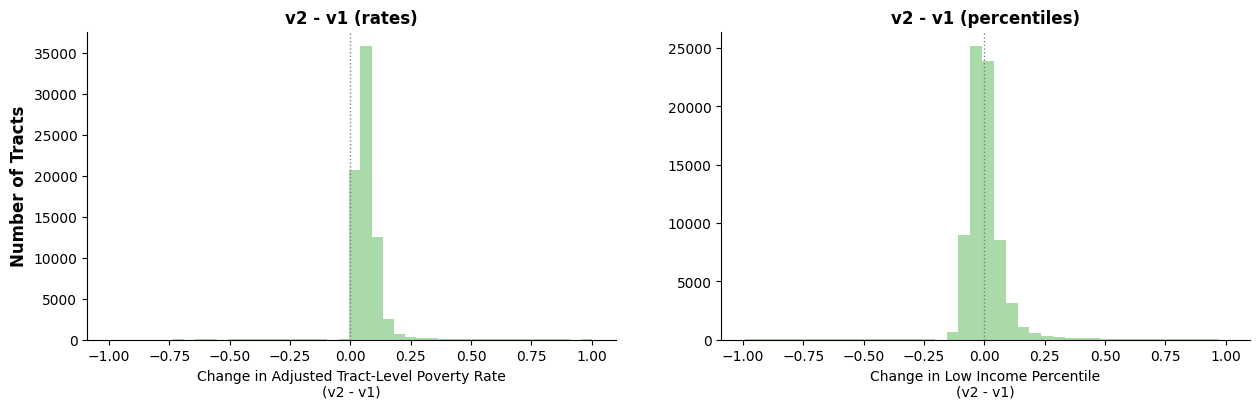

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True)

for m, method in enumerate(adjustments):
    nice_method = method.replace('_vs_', ' - ')
    if 'v1' in method and 'v2' in method:
        c= added_color
    elif 'v1' in method:
        c=v1_color
    elif 'v2' in method:
        c=v2_color
    ax[m].hist(scores[method], 
                  bins=40, alpha=0.4, color=c)
    if m==0:
        ax[m].set_ylabel('Number of Tracts', fontsize=12, fontweight='bold')
    if 'percentiles' in method:
        ax[m].set_title(nice_method.replace('_percentiles', ' (percentiles)'),
                           fontweight='bold')
    else:
        ax[m].set_title(nice_method + ' (rates)',
                           fontweight='bold')
    ax[m].xaxis.set_tick_params(labelbottom=True)
    if 'percentiles' in method:
        ax[m].set_xlabel(f"Change in Low Income Percentile\n({nice_method.replace('_percentiles', '')})")
    else:
        ax[m].set_xlabel(f"Change in Adjusted Tract-Level Poverty Rate\n({nice_method})")
    ax[m].spines[['right', 'top']].set_visible(False)
    ax[m].axvline(x=0, color='grey', linestyle='dotted', linewidth=1)
plt.subplots_adjust(hspace=0.65)

### Distribution of Changes, by Region

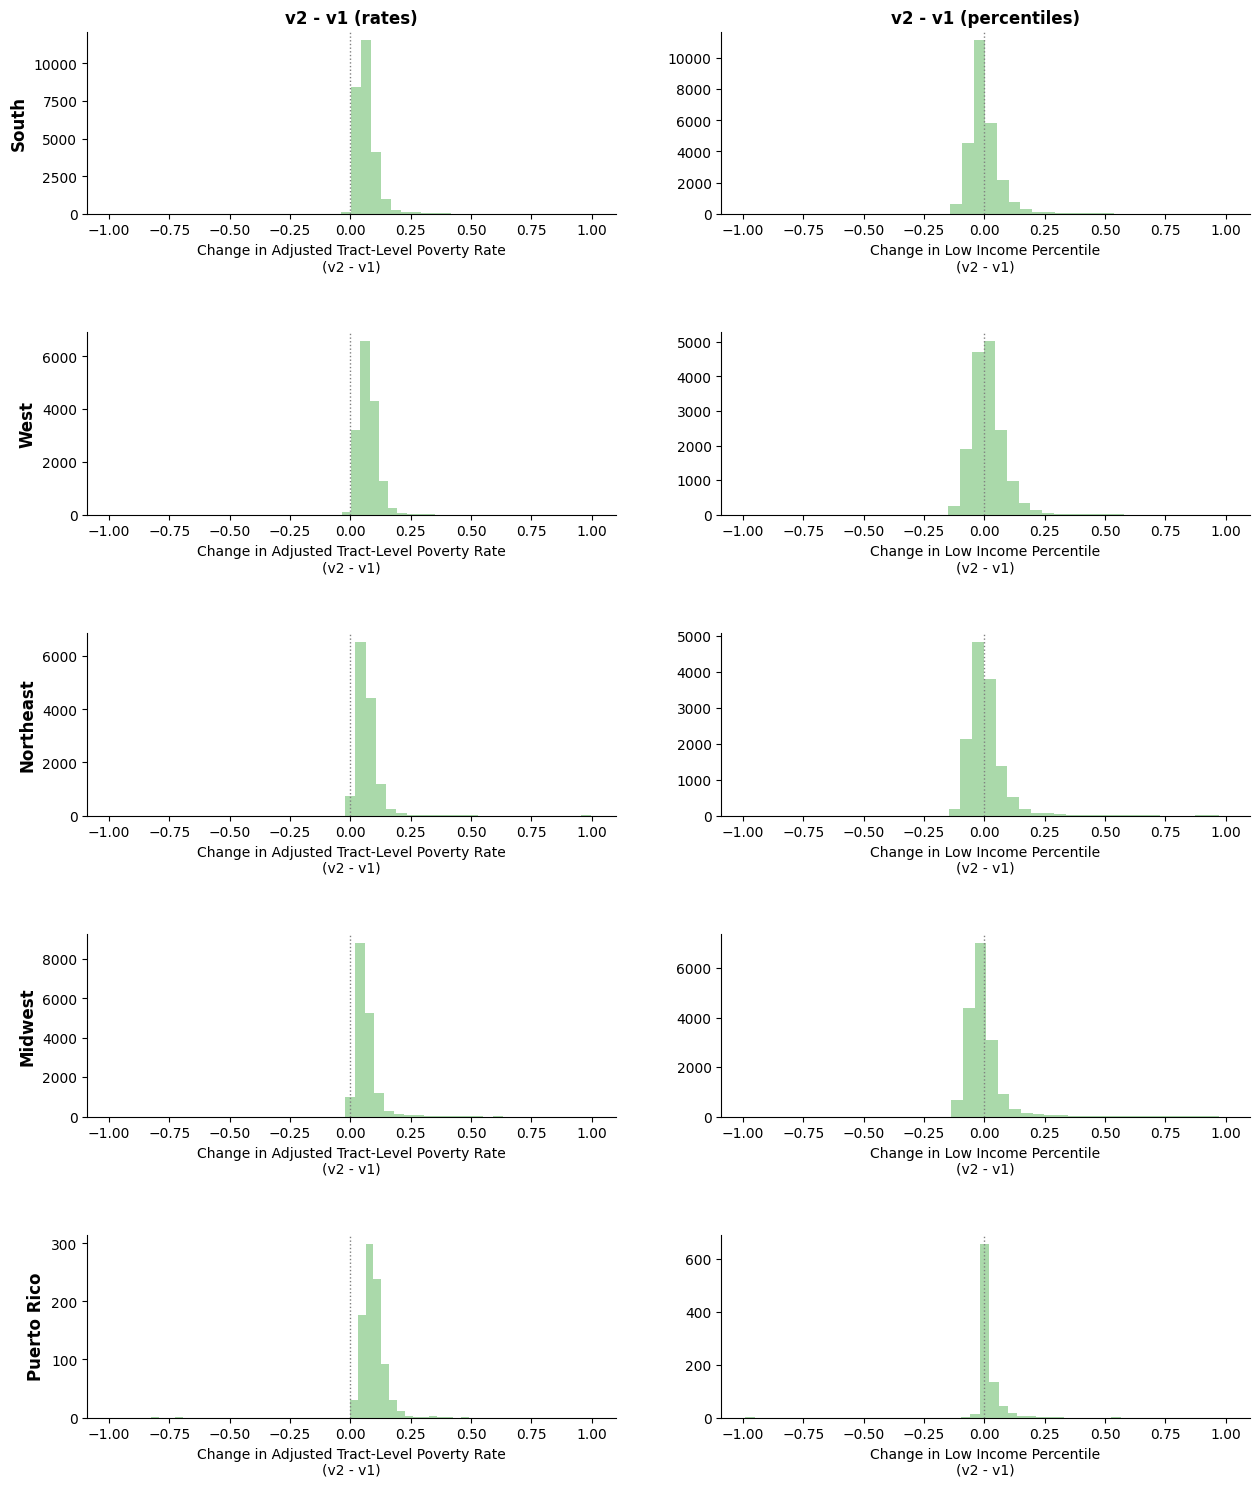

In [33]:
fig, ax = plt.subplots(5, 2, figsize=(15,18), sharex=True)

for r, region in enumerate([x for x in scores['region'].unique() if "Territories" not in x]):
    region_df = scores[scores.region==region]
    for m, method in enumerate(adjustments):
        nice_method = method.replace('_vs_', ' - ')
        if 'v1' in method and 'v2' in method:
            c= added_color
        elif 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[r][m].hist(region_df[method], 
                      bins=40, alpha=0.4, color=c)

        ax[r][m].spines[['right', 'top']].set_visible(False)
        ax[r][m].axvline(x=0, color='grey', linestyle='dotted', linewidth=1)
        if m==0:
            ax[r][m].set_ylabel(region, fontsize=12, fontweight='bold')
        if r==0:
            if 'percentiles' in method:
                ax[r][m].set_title(nice_method.replace('_percentiles', ' (percentiles)'),
                                   fontweight='bold')
            else:
                ax[r][m].set_title(nice_method + ' (rates)',
                                   fontweight='bold')
        ax[r][m].xaxis.set_tick_params(labelbottom=True)
        if 'percentiles' in method:
            ax[r][m].set_xlabel(f"Change in Low Income Percentile\n({nice_method.replace('_percentiles', '')})")
        else:
            ax[r][m].set_xlabel(f"Change in Adjusted Tract-Level Poverty Rate\n({nice_method})")
plt.subplots_adjust(hspace=0.65)

### Distribution of Changes, by University Enrollment Rate

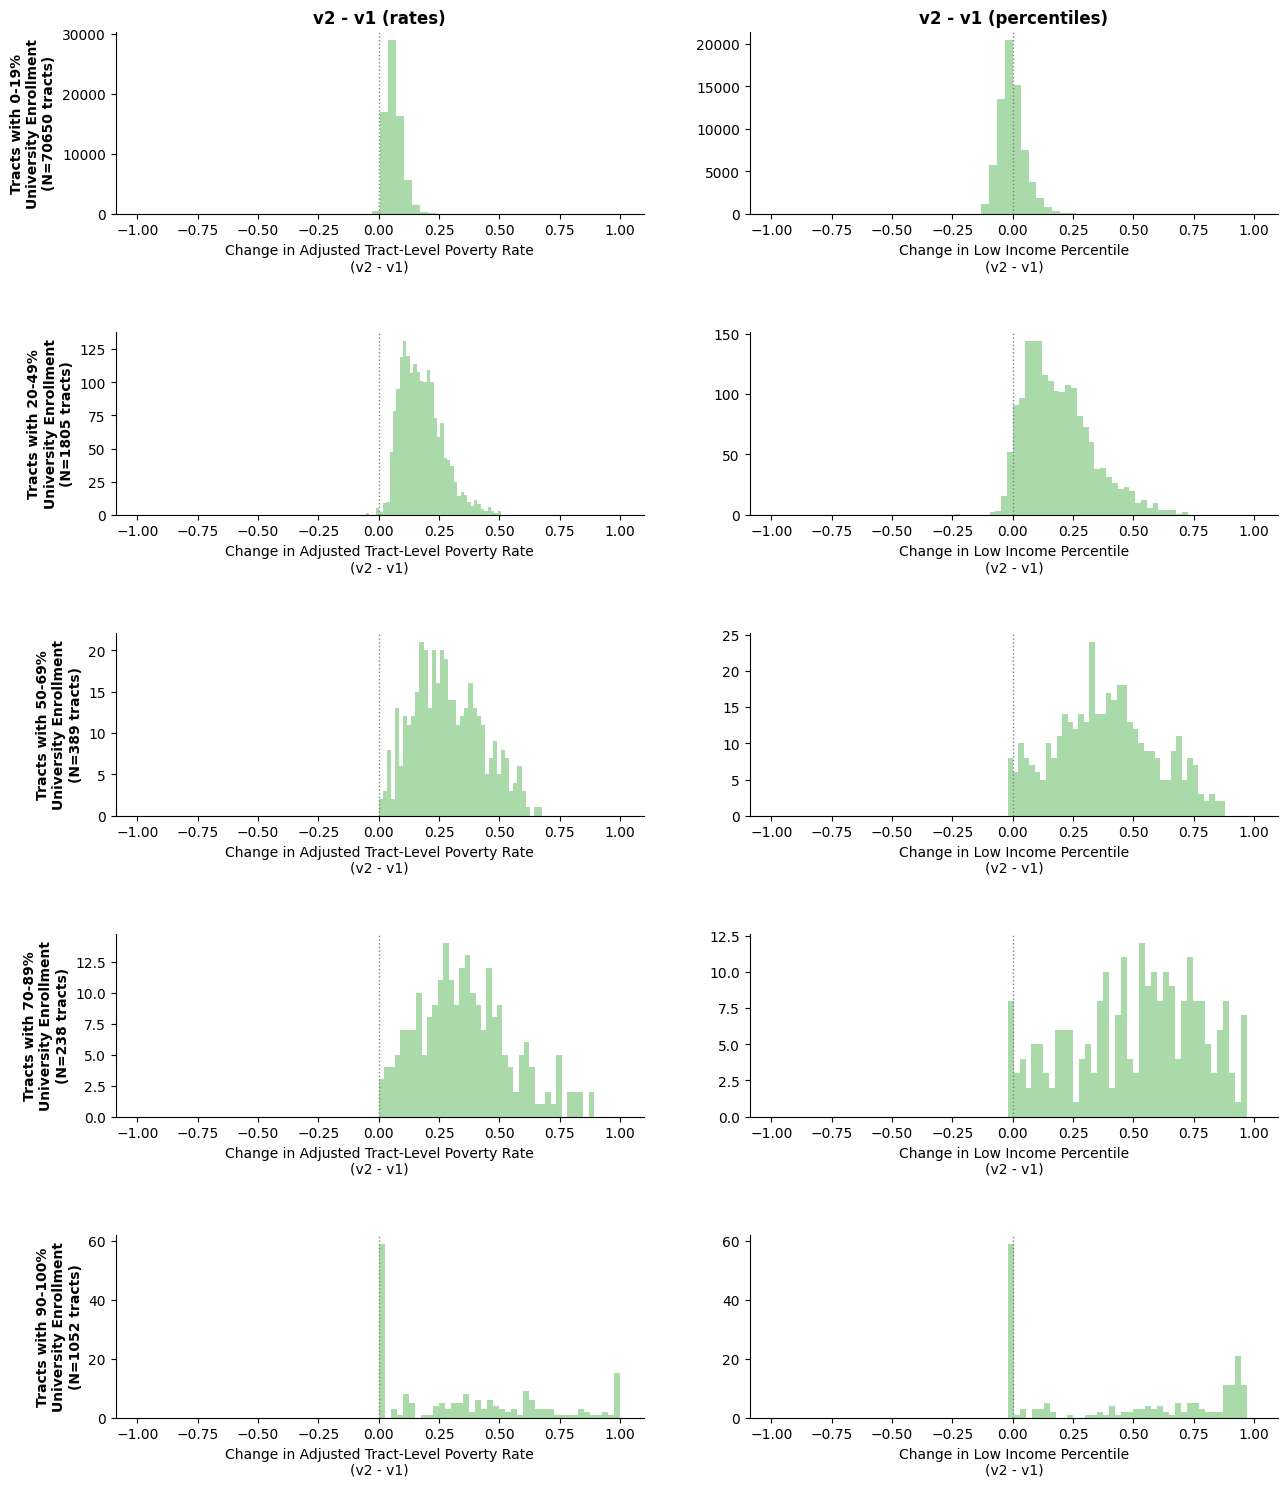

In [34]:
fig, ax = plt.subplots(5, 2, figsize=(15,18), sharex=True)

for b, bucket in enumerate(scores['university_attendance_bucketed'].unique()):
    bucket_df = scores[scores.university_attendance_bucketed==bucket]
    for m, method in enumerate(adjustments):
        nice_method = method.replace('_vs_', ' - ')
        if 'v1' in method and 'v2' in method:
            c=added_color
        elif 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], 
                      bins=40, alpha=0.4, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'Tracts with {bucket}\nUniversity Enrollment\n(N={len(bucket_df)} tracts)',
                               fontweight='bold')
        if b==0:
            if 'percentiles' in method:
                ax[b][m].set_title(nice_method.replace('_percentiles', ' (percentiles)'),
                                   fontweight='bold')
            else:
                ax[b][m].set_title(nice_method + ' (rates)',
                                   fontweight='bold')
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        if 'percentiles' in method:
            ax[b][m].set_xlabel(f"Change in Low Income Percentile\n({nice_method.replace('_percentiles', '')})")
        else:
            ax[b][m].set_xlabel(f"Change in Adjusted Tract-Level Poverty Rate\n({nice_method})")
        ax[b][m].spines[['right', 'top']].set_visible(False)
        ax[b][m].axvline(x=0, color='grey', linestyle='dotted', linewidth=1)
plt.subplots_adjust(hspace=0.65)

### Distribution of Changes, by Housing Density

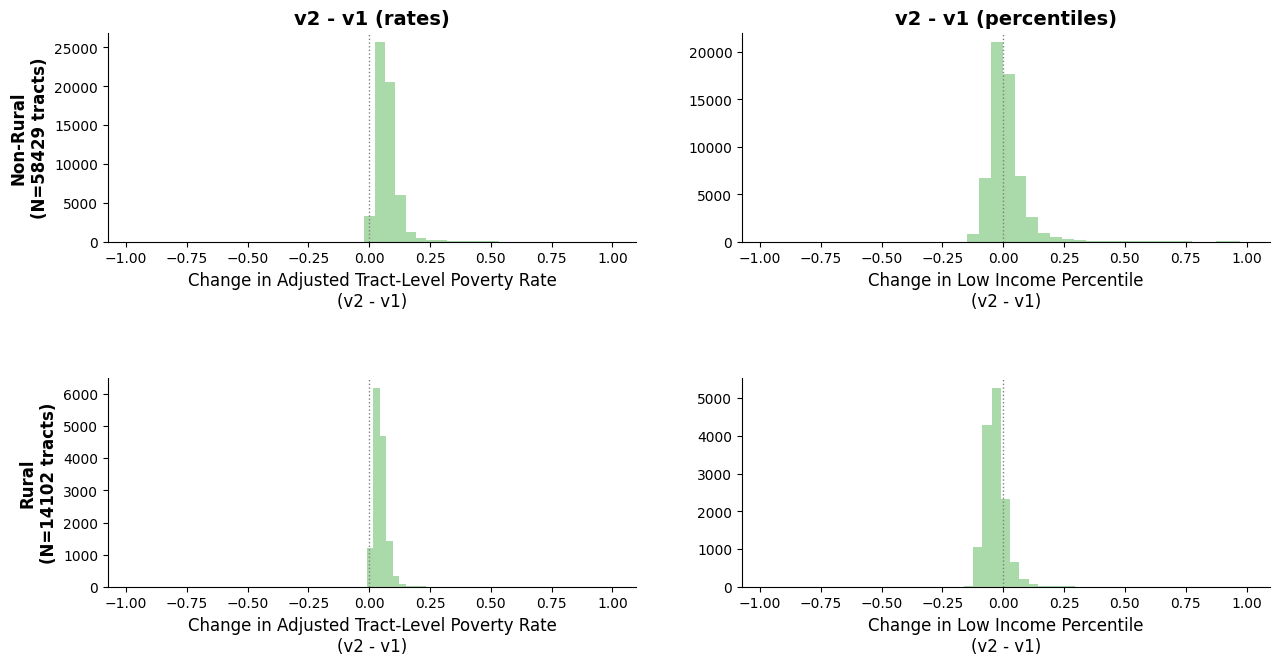

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(15,7.2), sharex=True)

for b, bucket in enumerate(scores['rural_flag_string'].unique()):
    if bucket!=bucket:
        continue
    bucket_df = scores[scores.rural_flag_string==bucket]
    for m, method in enumerate(adjustments):
        nice_method = method.replace('_vs_', ' - ')
        if 'v1' in method and 'v2' in method:
            c=added_color
        elif 'v1' in method:
            c=v1_color
        elif 'v2' in method:
            c=v2_color
        ax[b][m].hist(bucket_df[method], 
                      bins=40, alpha=0.4, color=c)
        if m==0:
            ax[b][m].set_ylabel(f'{bucket}\n(N={len(bucket_df)} tracts)',
                               fontweight='bold', fontsize=12)
        if b==0:
            if 'percentiles' in method:
                ax[b][m].set_title(nice_method.replace('_percentiles', ' (percentiles)'),
                                   fontweight='bold', fontsize=14)
            else:
                ax[b][m].set_title(nice_method + ' (rates)',
                                   fontweight='bold', fontsize=14)
        ax[b][m].xaxis.set_tick_params(labelbottom=True)
        if 'percentiles' in method:
            ax[b][m].set_xlabel(f"Change in Low Income Percentile\n({nice_method.replace('_percentiles', '')})",
                               fontsize=12)
        else:
            ax[b][m].set_xlabel(f"Change in Adjusted Tract-Level Poverty Rate\n({nice_method})", 
                               fontsize=12)
        ax[b][m].spines[['right', 'top']].set_visible(False)
        ax[b][m].axvline(x=0, color='grey', linestyle='dotted', linewidth=1)
plt.subplots_adjust(hspace=0.65)

## Percent Disadvantaged, by Tract and by Population

### Overall Summary: Percent Disadvantaged, by Tract and by Population

In [36]:
# Get the population living in a disadvantaged tract
scores['dac_population__v2'] = scores['Total population'] * scores['is_dac_final__v2'].astype(int)
scores['dac_population__v1'] = scores['Total population'] * scores['is_dac_final__v1'].astype(int)

# Get the population living in a grandfathered tract
scores['grandfathered_population'] = scores['Total population'] * scores['is_grandfathered'].astype(int)


overall_summary = pd.DataFrame(scores.agg({'Total population': 'sum',
                              'grandfathered_population': 'sum',
                              'dac_population__v2': 'sum',
                              'dac_population__v1': 'sum',
                              'is_dac_final__v2': 'mean', 
                              'is_dac_final__v1': 'mean',
                               })).T
overall_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = overall_summary['dac_population__v2']/overall_summary['Total population']

overall_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = overall_summary['dac_population__v1']/overall_summary['Total population']

overall_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = overall_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - overall_summary['Percent of Population in Disadvantaged Tracts, v1']

overall_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = overall_summary['grandfathered_population']/overall_summary['Total population']



overall_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

overall_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population'])

,Total Population,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1","Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
0,328230505.0,0.385343,0.367551,0.350878,0.332602,0.018276,0.017336


### Regional Summary: Percent Disadvantaged, by Tract and by Population

In [37]:
region_summary = scores.groupby(by='region').agg({'Total population': 'sum',
                                                  'grandfathered_population': 'sum',
                                                  'dac_population__v2': 'sum',
                                                  'dac_population__v1': 'sum',
                                                  'is_dac_final__v2': 'mean', 
                                                  'is_dac_final__v1': 'mean',
                                                   })
region_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = region_summary['dac_population__v2']/region_summary['Total population']

region_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = region_summary['dac_population__v1']/region_summary['Total population']

region_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = region_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - region_summary['Percent of Population in Disadvantaged Tracts, v1']

region_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = region_summary['grandfathered_population']/region_summary['Total population']

region_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

region_summary

,Total Population,grandfathered_population,dac_population__v2,dac_population__v1,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1","Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
region,,,,,,,,,,
Midwest,68093751.0,1550803.0,18773895.0,17687834.0,0.331832,0.316153,0.275707,0.259757,0.015949,0.022775
Northeast,55976418.0,789076.0,15601926.0,14995061.0,0.304380,0.292045,0.278723,0.267882,0.010841,0.014097
Other Territories,337961.0,0.0,280683.0,127244.0,0.734848,0.386364,0.830519,0.376505,0.454014,0.000000
Puerto Rico,3318447.0,2053.0,3138133.0,3060023.0,0.885714,0.871958,0.945663,0.922125,0.023538,0.000619
South,123401797.0,2411436.0,50810588.0,48453672.0,0.459632,0.441273,0.411749,0.392650,0.019100,0.019541
West,77102131.0,936737.0,26563598.0,24846128.0,0.356642,0.335422,0.344525,0.322250,0.022275,0.012149


In [38]:
region_summary = region_summary.reset_index().set_index(pd.Index([2,0,5,4,1,3])).sort_index()
region_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population',
                            'Percent of Tracts that are Disadvantaged, v2',
                            'Percent of Tracts that are Disadvantaged, v1'])

,region,Total Population,"Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
0,Northeast,55976418.0,0.278723,0.267882,0.010841,0.014097
1,South,123401797.0,0.411749,0.392650,0.019100,0.019541
2,Midwest,68093751.0,0.275707,0.259757,0.015949,0.022775
3,West,77102131.0,0.344525,0.322250,0.022275,0.012149
4,Puerto Rico,3318447.0,0.945663,0.922125,0.023538,0.000619
5,Other Territories,337961.0,0.830519,0.376505,0.454014,0.000000


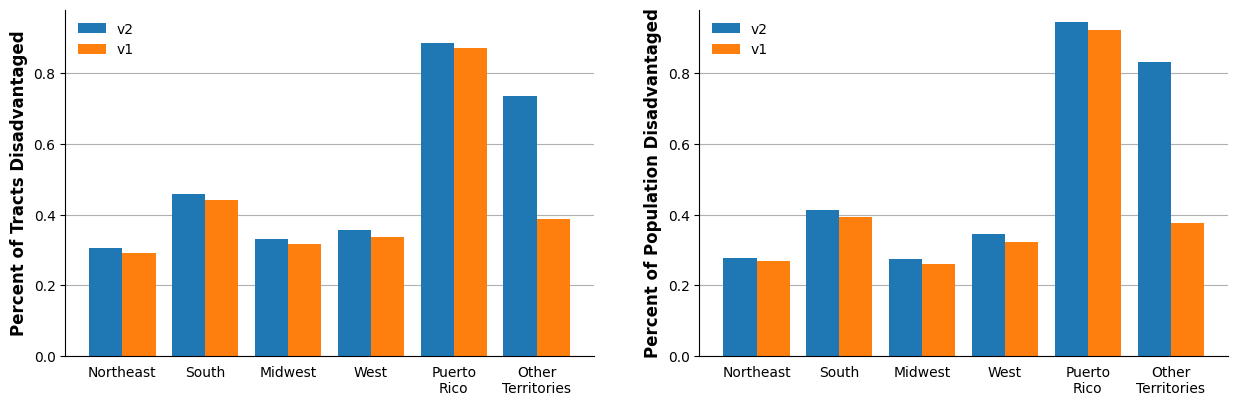

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15,4.5), sharex=True, sharey=False)

w = 0.4

for f, factor in enumerate(['Percent of Tracts that are Disadvantaged',
                            'Percent of Population in Disadvantaged Tracts']):
    for m, method in enumerate(['v2', 'v1']):
        ax[f].set_ylim([0,0.98])
        if 'v1' in method:
            c=v1_color
            ax[f].bar(x=np.arange(0,6,1)+(w/2),
                      height=region_summary[factor+', '+method], 
                      color=c, width=w, label='v1')
        elif 'v2' in method:
            c=v2_color
            ax[f].bar(x=np.arange(0,6,1)-(w/2),
                  height=region_summary[factor+', '+method], 
                  color=c, width=w, label='v2')
        ax[f].set_ylabel(f"{factor.split(' that ')[0].split(' in ')[0]} Disadvantaged",
                             fontsize=12,fontweight='bold')
        ax[f].legend(frameon=False, loc="upper left")
        ax[f].set_xticks(ticks=np.arange(0,6,1), fontsize=10,
                         labels=[x.replace(' ', '\n') for x in region_summary.region.values])
        ax[f].tick_params(axis="x", bottom=False)
        ax[f].spines[['right', 'top']].set_visible(False)
        ax[f].set_axisbelow(True)
        ax[f].yaxis.grid(True)
plt.subplots_adjust(hspace=0.5)
plt.show()

### Division Summary: Percent Disadvantaged, by Tract and by Population

In [40]:
division_summary = scores.groupby(by='division').agg({'Total population': 'sum',
                                                  'grandfathered_population': 'sum',
                                                  'dac_population__v2': 'sum',
                                                  'dac_population__v1': 'sum',
                                                  'is_dac_final__v2': 'mean', 
                                                  'is_dac_final__v1': 'mean',
                                                   })
division_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = division_summary['dac_population__v2']/division_summary['Total population']

division_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = division_summary['dac_population__v1']/division_summary['Total population']

division_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = division_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - division_summary['Percent of Population in Disadvantaged Tracts, v1']

division_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = division_summary['grandfathered_population']/division_summary['Total population']

division_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

division_summary

,Total Population,grandfathered_population,dac_population__v2,dac_population__v1,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1","Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
division,,,,,,,,,,
East North Central,46847712.0,968687.0,13596078.0,12893798.0,0.353489,0.339262,0.290219,0.275228,0.014991,0.020677
East South Central,19019076.0,481209.0,9050242.0,8705916.0,0.545659,0.527260,0.475851,0.457747,0.018104,0.025301
Middle Atlantic,41185631.0,671098.0,12525373.0,12072679.0,0.327486,0.314674,0.304120,0.293128,0.010992,0.016294
Mountain,24138879.0,463963.0,7681757.0,7062671.0,0.345143,0.320952,0.318232,0.292585,0.025647,0.019221
New England,14790787.0,117978.0,3076553.0,2922382.0,0.235259,0.224351,0.208005,0.197581,0.010423,0.007976
Other Territories,337961.0,0.0,280683.0,127244.0,0.734848,0.386364,0.830519,0.376505,0.454014,0.000000
Pacific,52963252.0,472774.0,18881841.0,17783457.0,0.362197,0.342413,0.356508,0.335770,0.020739,0.008926
Puerto Rico,3318447.0,2053.0,3138133.0,3060023.0,0.885714,0.871958,0.945663,0.922125,0.023538,0.000619
South Atlantic,64525263.0,1163784.0,22848067.0,21722405.0,0.385671,0.368452,0.354095,0.336650,0.017445,0.018036


In [41]:
division_summary = division_summary.reset_index().set_index(pd.Index([5,3,1,7,0,10,8,9,2,6,4])).sort_index()
division_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population',
                            'Percent of Tracts that are Disadvantaged, v2',
                            'Percent of Tracts that are Disadvantaged, v1'])

,division,Total Population,"Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
0,New England,14790787.0,0.208005,0.197581,0.010423,0.007976
1,Middle Atlantic,41185631.0,0.304120,0.293128,0.010992,0.016294
2,South Atlantic,64525263.0,0.354095,0.336650,0.017445,0.018036
3,East South Central,19019076.0,0.475851,0.457747,0.018104,0.025301
4,West South Central,39857458.0,0.474498,0.452245,0.022252,0.019230
5,East North Central,46847712.0,0.290219,0.275228,0.014991,0.020677
6,West North Central,21246039.0,0.243707,0.225644,0.018064,0.027399
7,Mountain,24138879.0,0.318232,0.292585,0.025647,0.019221
8,Pacific,52963252.0,0.356508,0.335770,0.020739,0.008926
9,Puerto Rico,3318447.0,0.945663,0.922125,0.023538,0.000619


### State Summary: Percent Disadvantaged, by Tract and by Population

In [42]:
state_summary = scores.groupby(by='state').agg({'Total population': 'sum',
                                                'grandfathered_population': 'sum',
                                                  'dac_population__v2': 'sum',
                                                  'dac_population__v1': 'sum',
                                                  'is_dac_final__v2': 'mean', 
                                                  'is_dac_final__v1': 'mean',
                                                   })
state_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = state_summary['dac_population__v2']/state_summary['Total population']

state_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = state_summary['dac_population__v1']/state_summary['Total population']

state_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = state_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - state_summary['Percent of Population in Disadvantaged Tracts, v1']

state_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = state_summary['grandfathered_population']/state_summary['Total population']


state_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

state_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population',
                            'Percent of Tracts that are Disadvantaged, v2',
                            'Percent of Tracts that are Disadvantaged, v1'])

,Total Population,"Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
state,,,,,
AK,728818.0,0.186834,0.179419,0.007415,0.021808
AL,4876250.0,0.475099,0.457116,0.017982,0.024052
AR,2999370.0,0.575122,0.546933,0.028190,0.038803
AS (American Samoa),49710.0,1.000000,1.000000,0.000000,0.000000
AZ,7017423.0,0.370506,0.354567,0.015939,0.013854
CA,39278430.0,0.401713,0.378900,0.022814,0.006277
CO,5610349.0,0.202849,0.189101,0.013748,0.014591
CT,3575074.0,0.211459,0.197578,0.013881,0.005359
DC,692683.0,0.344901,0.331743,0.013158,0.000000


### University Summary: Perce|nt Disadvantaged, by Tract and by Population

In [43]:
uni_summary = scores.groupby(by='university_attendance_bucketed').agg({'Total population': 'sum',
                                                                       'grandfathered_population': 'sum',
                                                                      'dac_population__v2': 'sum',
                                                                      'dac_population__v1': 'sum',
                                                                      'is_dac_final__v2': 'mean', 
                                                                      'is_dac_final__v1': 'mean',
                                                                       })
uni_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = uni_summary['dac_population__v2']/uni_summary['Total population']

uni_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = uni_summary['dac_population__v1']/uni_summary['Total population']

uni_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = uni_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - uni_summary['Percent of Population in Disadvantaged Tracts, v1']

uni_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

uni_summary[ 
    'Percent of Tracts Re-Classified as Disadvantaged'
    ] = uni_summary['Percent of Tracts that are Disadvantaged, v2']\
        - uni_summary['Percent of Tracts that are Disadvantaged, v1']

uni_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = uni_summary['grandfathered_population']/uni_summary['Total Population']

uni_summary.reset_index(inplace=True)

uni_summary

,university_attendance_bucketed,Total Population,grandfathered_population,dac_population__v2,dac_population__v1,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1","Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Tracts Re-Classified as Disadvantaged,Percent of Population in Grandfathered Tracts
0,0-19%,316211842.0,5690105.0,110733165.0,106594635.0,0.388705,0.376207,0.350187,0.337099,0.013088,0.012498,0.017995
1,20-49%,7920786.0,0.0,2403440.0,1594173.0,0.336288,0.227701,0.303435,0.201264,0.102170,0.108587,0.000000
2,50-69%,1810073.0,0.0,771047.0,464731.0,0.447301,0.272494,0.425976,0.256747,0.169229,0.174807,0.000000
3,70-89%,1165625.0,0.0,558456.0,228016.0,0.512605,0.205882,0.479104,0.195617,0.283487,0.306723,0.000000
4,90-100%,1122179.0,0.0,702715.0,288407.0,0.192015,0.097909,0.626206,0.257006,0.369200,0.094106,0.000000


In [44]:
uni_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population',
                            'Percent of Population in Disadvantaged Tracts, v2',
                            'Percent of Population in Disadvantaged Tracts, v1',
                         'Percent of Population in Newly Added Disadvantaged Tracts'])

,university_attendance_bucketed,Total Population,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1",Percent of Tracts Re-Classified as Disadvantaged,Percent of Population in Grandfathered Tracts
0,0-19%,316211842.0,0.388705,0.376207,0.012498,0.017995
1,20-49%,7920786.0,0.336288,0.227701,0.108587,0.000000
2,50-69%,1810073.0,0.447301,0.272494,0.174807,0.000000
3,70-89%,1165625.0,0.512605,0.205882,0.306723,0.000000
4,90-100%,1122179.0,0.192015,0.097909,0.094106,0.000000


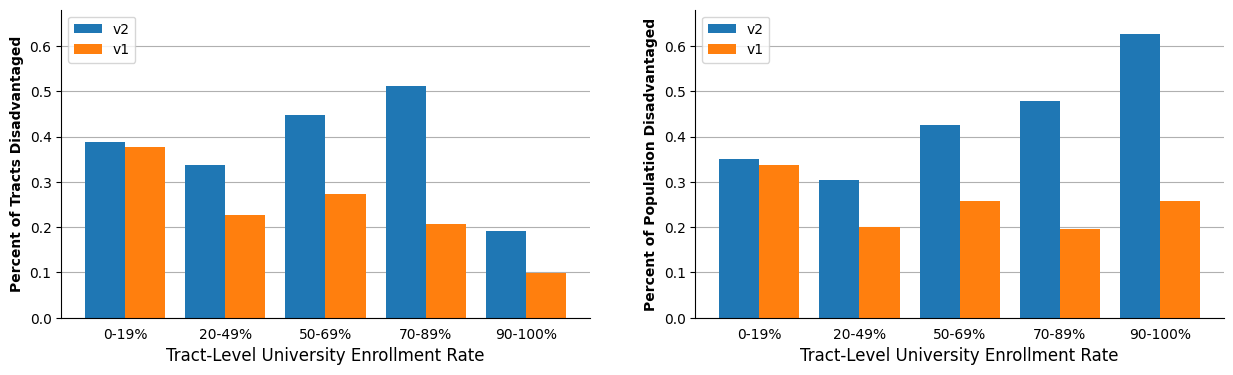

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True, sharey=False)

w = 0.4

for f, factor in enumerate(['Percent of Tracts that are Disadvantaged',
                            'Percent of Population in Disadvantaged Tracts']):
    for m, method in enumerate(['v2', 'v1']):
        ax[f].set_ylim([0,0.68])
        if 'v1' in method:
            c=v1_color
            ax[f].bar(x=np.arange(0,5,1)+(w/2),
                      height=uni_summary[factor+', '+method], 
                      color=c, width=w, label='v1')
        elif 'v2' in method:
            c=v2_color
            ax[f].bar(x=np.arange(0,5,1)-(w/2),
                  height=uni_summary[factor+', '+method], 
                  color=c, width=w, label='v2')
        ax[f].set_ylabel(f"{factor.split(' that ')[0].split(' in ')[0]} Disadvantaged",
                             fontsize=10,fontweight='bold')
        ax[f].set_xlabel('Tract-Level University Enrollment Rate',fontsize=12)
        ax[f].legend(frameon=True, loc="upper left")
        ax[f].set_xticks(ticks=np.arange(0,5,1), fontsize=10,
                    labels=[x.replace(' ', '\n') for x in uni_summary['university_attendance_bucketed'].values],)
        ax[f].tick_params(axis="x", bottom=False)
        ax[f].spines[['right', 'top']].set_visible(False)
        ax[f].set_axisbelow(True)
        ax[f].yaxis.grid(True)
plt.subplots_adjust(hspace=0.5)
plt.show()

### Housing Density Summary: Percent Disadvantaged, by Tract and by Population

In [46]:
rural_summary = scores.groupby(by='rural_flag_string').agg({'Total population': 'sum',
                                                                       'grandfathered_population': 'sum',
                                                                      'dac_population__v2': 'sum',
                                                                      'dac_population__v1': 'sum',
                                                                      'is_dac_final__v2': 'mean', 
                                                                      'is_dac_final__v1': 'mean',
                                                                       })
rural_summary[ 
    'Percent of Population in Disadvantaged Tracts, v2'
] = rural_summary['dac_population__v2']/rural_summary['Total population']

rural_summary[ 
    'Percent of Population in Disadvantaged Tracts, v1'
] = rural_summary['dac_population__v1']/rural_summary['Total population']

rural_summary[ 
    'Percent of Population in Newly Added Disadvantaged Tracts'
    ] = rural_summary['Percent of Population in Disadvantaged Tracts, v2']\
        - rural_summary['Percent of Population in Disadvantaged Tracts, v1']

rural_summary.rename(columns={'is_dac_final__v2': 'Percent of Tracts that are Disadvantaged, v2',
                               'is_dac_final__v1': 'Percent of Tracts that are Disadvantaged, v1',
                               'Total population': 'Total Population'}, inplace=True)

rural_summary[ 
    'Percent of Tracts Re-Classified as Disadvantaged'
    ] = rural_summary['Percent of Tracts that are Disadvantaged, v2']\
        - rural_summary['Percent of Tracts that are Disadvantaged, v1']

rural_summary[ 
    'Percent of Population in Grandfathered Tracts'
] = rural_summary['grandfathered_population']/rural_summary['Total Population']

rural_summary.reset_index(inplace=True)

rural_summary

,rural_flag_string,Total Population,grandfathered_population,dac_population__v2,dac_population__v1,"Percent of Tracts that are Disadvantaged, v2","Percent of Tracts that are Disadvantaged, v1","Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Tracts Re-Classified as Disadvantaged,Percent of Population in Grandfathered Tracts
0,Non-Rural,269100149.0,2910849.0,91929264.0,86550046.0,0.380855,0.360951,0.341617,0.321628,0.019990,0.019904,0.010817
1,Rural,55463237.0,2773941.0,19816371.0,19428277.0,0.380939,0.374060,0.357288,0.350291,0.006997,0.006878,0.050014


In [47]:
rural_summary.drop(columns=['dac_population__v2', 'dac_population__v1', 'grandfathered_population',
                            'Percent of Tracts that are Disadvantaged, v2',
                            'Percent of Tracts that are Disadvantaged, v1',
                         'Percent of Tracts Re-Classified as Disadvantaged'])

,rural_flag_string,Total Population,"Percent of Population in Disadvantaged Tracts, v2","Percent of Population in Disadvantaged Tracts, v1",Percent of Population in Newly Added Disadvantaged Tracts,Percent of Population in Grandfathered Tracts
0,Non-Rural,269100149.0,0.341617,0.321628,0.019990,0.010817
1,Rural,55463237.0,0.357288,0.350291,0.006997,0.050014


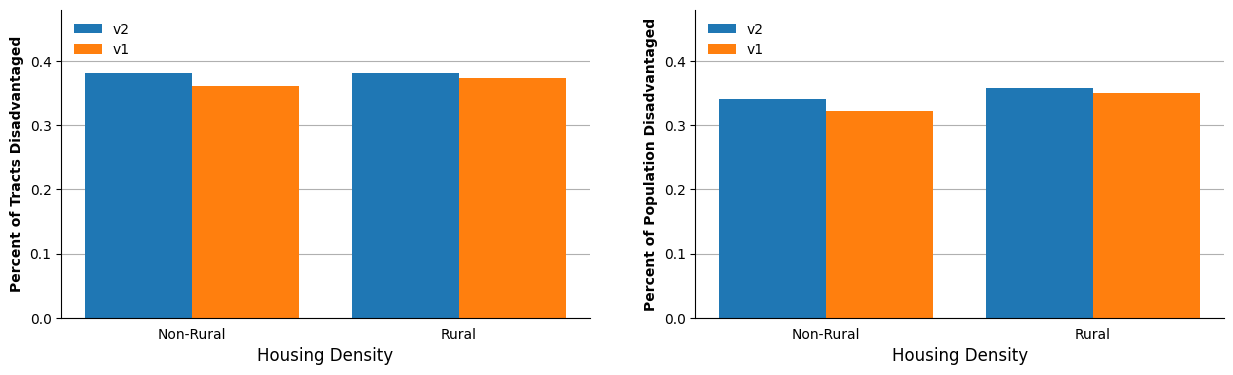

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(15,4), sharex=True, sharey=False)

w = 0.4

for f, factor in enumerate(['Percent of Tracts that are Disadvantaged',
                            'Percent of Population in Disadvantaged Tracts']):
    for m, method in enumerate(['v2', 'v1']):
        ax[f].set_ylim([0,0.48])
        if 'v1' in method:
            c=v1_color
            ax[f].bar(x=np.arange(0,2,1)+(w/2),
                      height=rural_summary[factor+', '+method], 
                      color=c, width=w, label='v1')
        elif 'v2' in method:
            c=v2_color
            ax[f].bar(x=np.arange(0,2,1)-(w/2),
                  height=rural_summary[factor+', '+method], 
                  color=c, width=w, label='v2')
        ax[f].set_ylabel(f"{factor.split(' that ')[0].split(' in ')[0]} Disadvantaged",
                             fontsize=10,fontweight='bold')
        ax[f].set_xlabel('Housing Density',fontsize=12)
        ax[f].legend(frameon=False, loc="upper left")
        ax[f].set_xticks(ticks=np.arange(0,2,1), fontsize=10,
                    labels=[x.replace(' ', '\n') for x in rural_summary['rural_flag_string'].values])
        ax[f].tick_params(axis="x", bottom=False)
        ax[f].spines[['right', 'top']].set_visible(False)
        ax[f].set_axisbelow(True)
        ax[f].yaxis.grid(True)
plt.subplots_adjust(hspace=0.5)
plt.show()

## Demographic Profiles of DACs

In [49]:
age_cols = [
    'Percent age under 10',
     'Percent age over 64',
]

education_cols = [
     'Percent individuals age 25 or over with less than high school degree',
     'Percent enrollment in college or graduate school',
]

In [50]:
hist_bins = list(np.arange(0, 1.01, 0.05))

### Age Breakdown

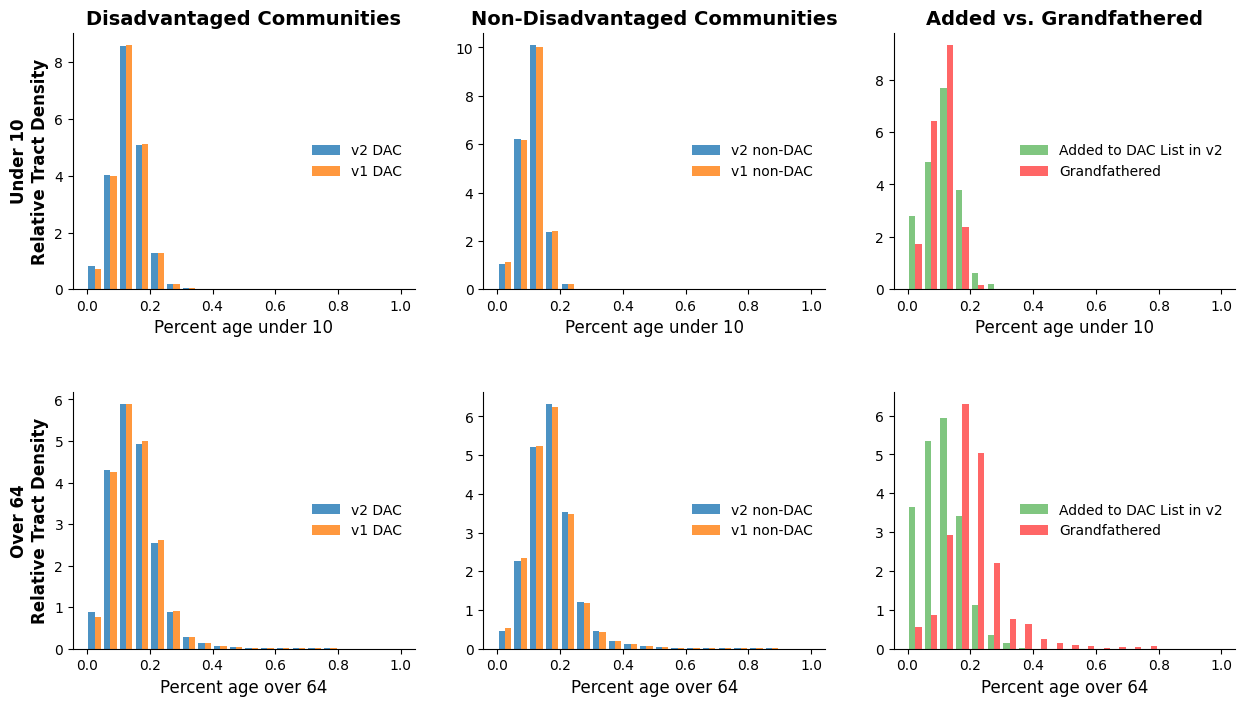

In [51]:
fig, ax = plt.subplots(2, 3, figsize=(15,8), sharex=False)

grandfathered_df = scores[scores.is_grandfathered]
added_df = scores[(scores.is_dac_final__v2==True) & (scores.is_dac_final__v1==False)]
v2_dac_df = scores[scores.is_dac_final__v2==True]
v2_nondac_df = scores[scores.is_dac_final__v2==False]
v1_dac_df = scores[scores.is_dac_final__v1==True]
v1_nondac_df = scores[scores.is_dac_final__v1==False]

for a, age in enumerate(age_cols):
    ax[a][0].hist([v2_dac_df[age], v1_dac_df[age]], 
                  density=True, bins=hist_bins, alpha=0.8, color=[v2_color, v1_color], 
                  label = ['v2 DAC', 'v1 DAC'])
    
    ax[a][1].hist([v2_nondac_df[age], v1_nondac_df[age]], 
                  density=True, bins=hist_bins, alpha=0.8, color=[v2_color, v1_color], 
                  label = ['v2 non-DAC', 'v1 non-DAC'])
    
    ax[a][2].hist([added_df[age], grandfathered_df[age]], 
                  density=True, bins=hist_bins, alpha=0.6, color=[added_color, removed_color], 
                  label = ['Added to DAC List in v2', 'Grandfathered'])
    
    ax[a][0].set_ylabel(age.replace('Percent age ', '').replace('under', 'Under').replace('over', 'Over')\
                        +'\nRelative Tract Density', 
                        fontweight='bold', fontsize=12)
    for j in range(3):
        ax[a][j].set_xlabel(age, fontsize=12)
        ax[a][j].spines[['right', 'top']].set_visible(False)
        ax[a][j].legend(frameon=False, fontsize=10, loc='center right')
    if a==0:
        ax[a][0].set_title('Disadvantaged Communities', fontweight='bold', fontsize=14)
        ax[a][1].set_title('Non-Disadvantaged Communities', fontweight='bold', fontsize=14)
        ax[a][2].set_title('Added vs. Grandfathered', fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.4)
plt.show()

### Education Breakdown

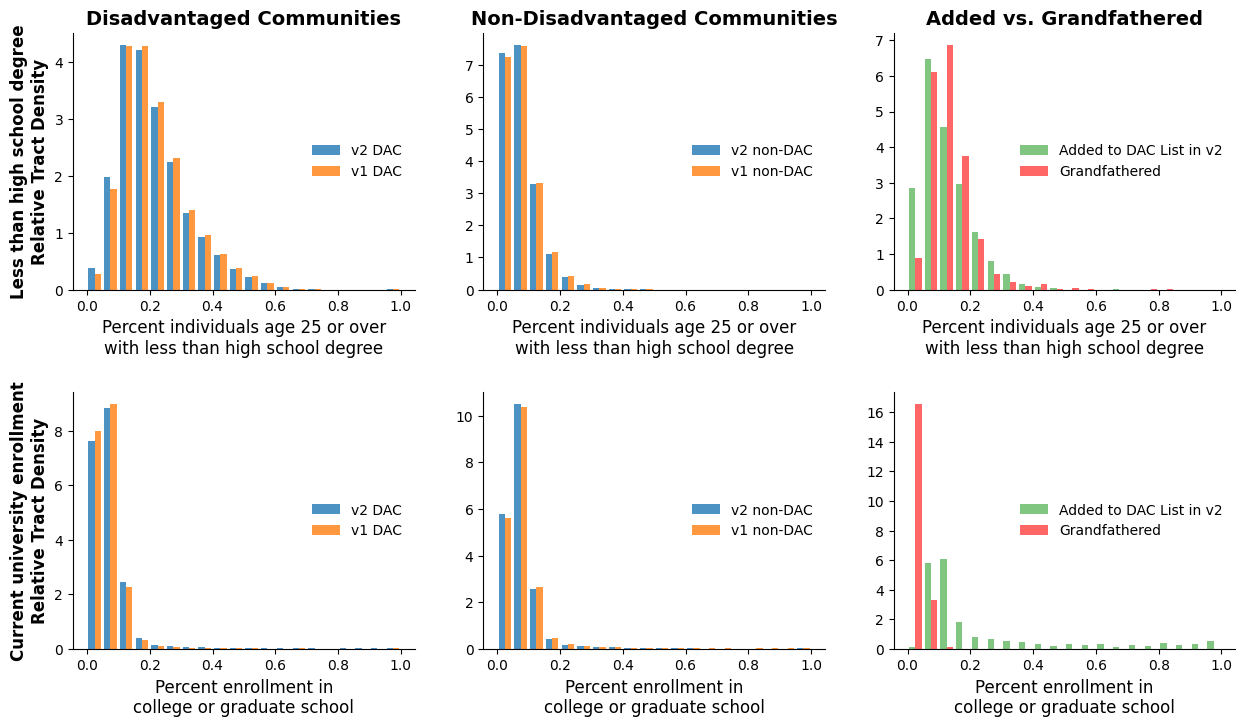

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(15,8), sharex=False)

for e, ed in enumerate(education_cols):
    ax[e][0].hist([v2_dac_df[ed], v1_dac_df[ed]], density=True, bins=hist_bins, alpha=0.8, 
           color=[v2_color, v1_color], label = ['v2 DAC', 'v1 DAC'])
    
    ax[e][1].hist([v2_nondac_df[ed], v1_nondac_df[ed]], density=True, bins=hist_bins, alpha=0.8, 
           color=[v2_color, v1_color], label = ['v2 non-DAC', 'v1 non-DAC'])
    
    ax[e][2].hist([added_df[ed], grandfathered_df[ed]], density=True, bins=hist_bins, alpha=0.6, 
           color=[added_color, removed_color], label = ['Added to DAC List in v2', 'Grandfathered'])
    
    if e==0:
        ax[e][0].set_ylabel('Less than high school degree'+'\nRelative Tract Density', 
                            fontweight='bold', fontsize=12)
    elif e==1:
         ax[e][0].set_ylabel('Current university enrollment'+'\nRelative Tract Density',
                             fontweight='bold', fontsize=12)
    for j in range(3):
        ax[e][j].set_xlabel(ed.replace(' over ', ' over\n').replace(' in ', ' in\n'), fontsize=12)
        ax[e][j].spines[['right', 'top']].set_visible(False)
        ax[e][j].legend(frameon=False, fontsize=10, loc='center right')
    if e==0:
        ax[e][0].set_title('Disadvantaged Communities', fontweight='bold', fontsize=14)
        ax[e][1].set_title('Non-Disadvantaged Communities', fontweight='bold', fontsize=14)
        ax[e][2].set_title('Added vs. Grandfathered', fontweight='bold', fontsize=14)
plt.subplots_adjust(hspace=0.4)
plt.show()

## How Often is Re-Assignment Due to Shifting Median?

In [53]:
print('Added DACs with <1% change to poverty rate: '+\
      str(round(100*len(added_df[added_df['v2_vs_v1']<0.01])/len(added_df), 1)) + '%')

Added DACs with <1% change to poverty rate: 0.1%


In [54]:
print('Added DACs with <5% change to poverty rate: '+\
      str(round(100*len(added_df[added_df['v2_vs_v1']<0.05])/len(added_df), 1)) + '%')

Added DACs with <5% change to poverty rate: 0.9%


In [55]:
print('Added DACs with <10% change to poverty rate: '+\
      str(round(100*len(added_df[added_df['v2_vs_v1']<0.10])/len(added_df), 1)) + '%')

Added DACs with <10% change to poverty rate: 21.6%


## Check nulls

In [56]:
for m in methods:
    print(m)
    print(f'Total nulls:{sum(scores[m].isna())}')
    nonzero_nulls = sum(scores[scores["Total population"]>0][m].isna())
    print(f'Nulls in tracts with non-zero total population: {nonzero_nulls}')
    nonterr_nulls = sum(scores[scores.region=='Territories'][m].isna())
    print(f'Nulls in tracts in states: {nonterr_nulls}')
    print('\n')

poverty_rate__v2
Total nulls:41
Nulls in tracts with non-zero total population: 0
Nulls in tracts in states: 0


poverty_rate__v1
Total nulls:861
Nulls in tracts with non-zero total population: 117
Nulls in tracts in states: 0




## How big was our estimate of university students in poverty?

In [58]:
path_to_score_census_acs_file = DATA_DIR / "dataset/census_acs/usa.csv"

census_acs = pd.read_csv(
    path_to_score_census_acs_file,
    dtype={'GEOID10_TRACT': "string"},
).rename(columns=column_dict)

In [59]:
census_acs.columns

Index(['GEOID10_TRACT', 'Total population', 'Unemployment (percent)',
       'Linguistic isolation (percent)',
       'Median household income in the past 12 months',
       'Percent of individuals < 100% Federal Poverty Line',
       'Percent of individuals < 150% Federal Poverty Line',
       'Percent of individuals < 200% Federal Poverty Line, imputed',
       'Total population of individuals < 200% Federal Poverty Line',
       'Total population of individuals < 200% Federal Poverty Line, imputed',
       'Median value ($) of owner-occupied housing units',
       'Percent individuals age 25 or over with less than high school degree',
       'B14006_009E', 'B14006_010E', 'B14006_019E', 'B14006_020E',
       'Ratio <200% FPL to <100% FPL, overall',
       'Estimated population count of off-campus university students <200% FPL',
       'Estimated population count of people in a househould with income <200% FPL, excluding all university students',
       'Everyone in poverty dataset, m

In [60]:
census_acs['Estimated population count of off-campus university students <200% FPL'].sum()

8230042.274530389